<a href="https://www.kaggle.com/code/huanyanlim/house-price-prediction?scriptVersionId=202746695" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Goal**:Predict the sales price of the house

**Target variable**: SalePrice

**Evaluation Metrics**: RMSE between the logarithms of the predicted value and the logarithm of the observed sales price

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble  import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Loading Data

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train.shape
#test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
#data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt')
#data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt')

(1460, 81)

In [3]:
train

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
#Numerical and categorical columns
cat_cols=[col for col in train.columns if train[col].dtype=='object']
num_cols=[col for col in train.columns if train[col].dtype!='object']

In [6]:
#Unique values of categorical columns
for col in cat_cols:
    unique_val=train[col].unique()
    print(f"Unique values in columnn '{col}':")
    print(unique_val)
    print("\n"+"="*60+"\n")

Unique values in columnn 'MSZoning':
['RL' 'RM' 'C (all)' 'FV' 'RH']


Unique values in columnn 'Street':
['Pave' 'Grvl']


Unique values in columnn 'Alley':
[nan 'Grvl' 'Pave']


Unique values in columnn 'LotShape':
['Reg' 'IR1' 'IR2' 'IR3']


Unique values in columnn 'LandContour':
['Lvl' 'Bnk' 'Low' 'HLS']


Unique values in columnn 'Utilities':
['AllPub' 'NoSeWa']


Unique values in columnn 'LotConfig':
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


Unique values in columnn 'LandSlope':
['Gtl' 'Mod' 'Sev']


Unique values in columnn 'Neighborhood':
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


Unique values in columnn 'Condition1':
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']


Unique values in columnn 'Condition2':
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'R

In [7]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

# EDA

**Univariate EDA**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

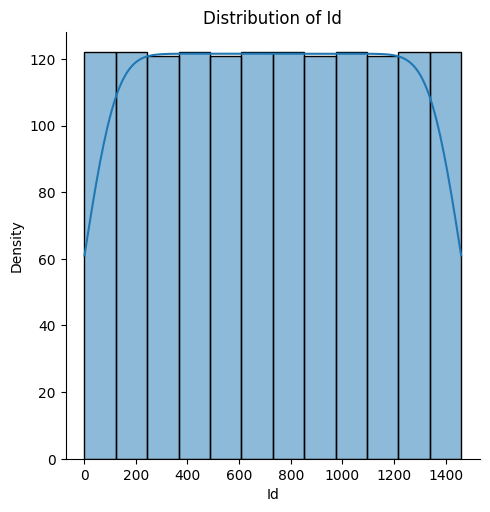

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

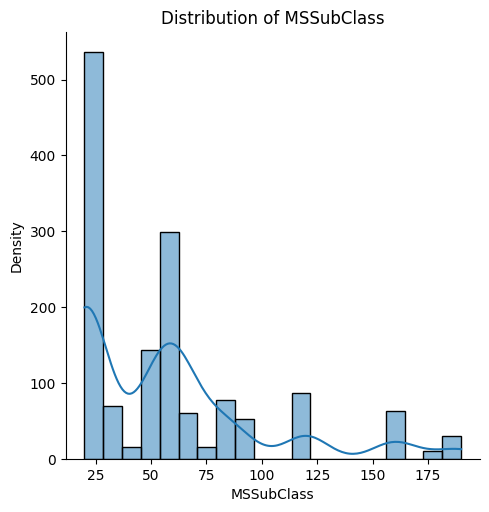

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

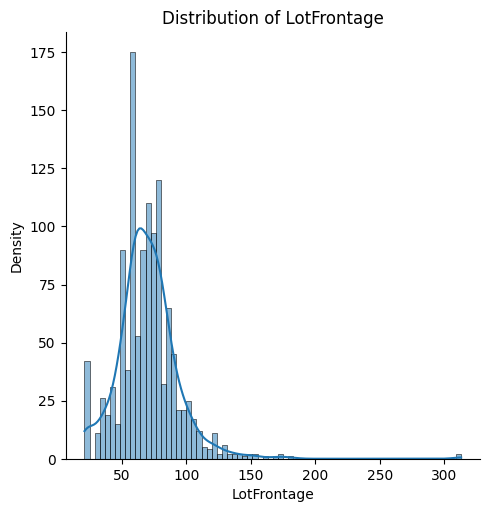

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

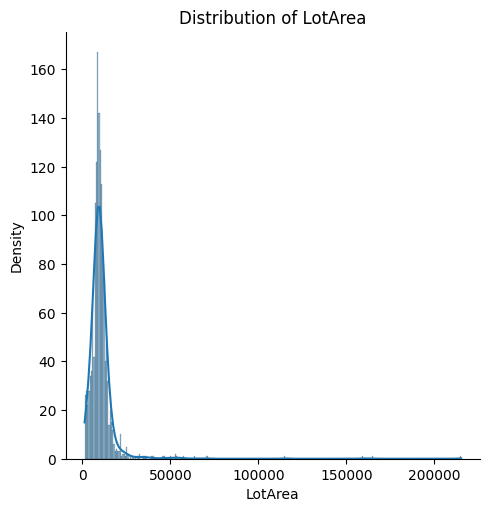

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

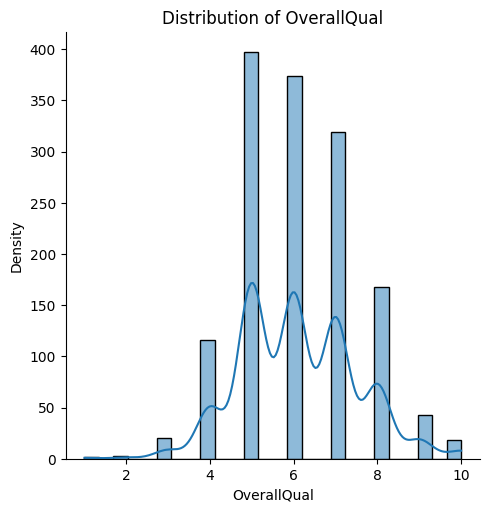

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

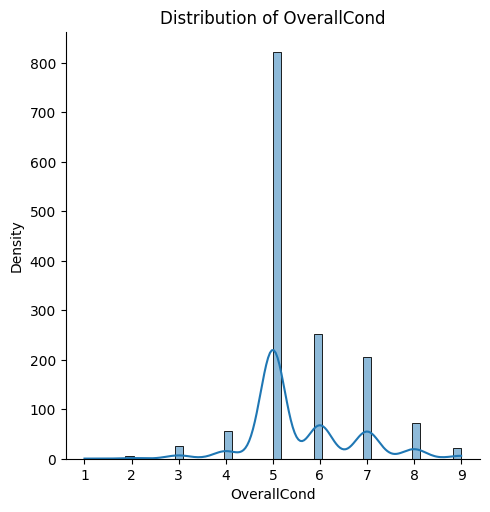

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

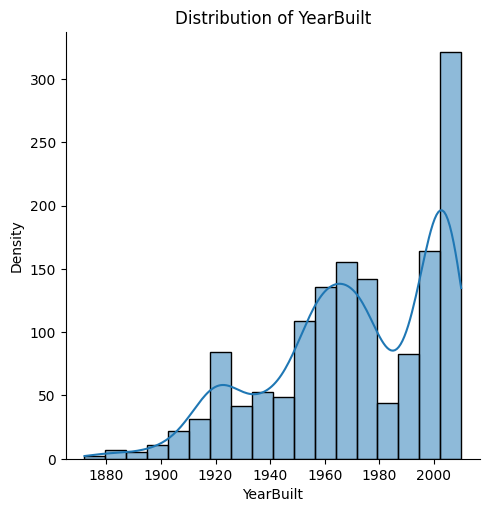

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

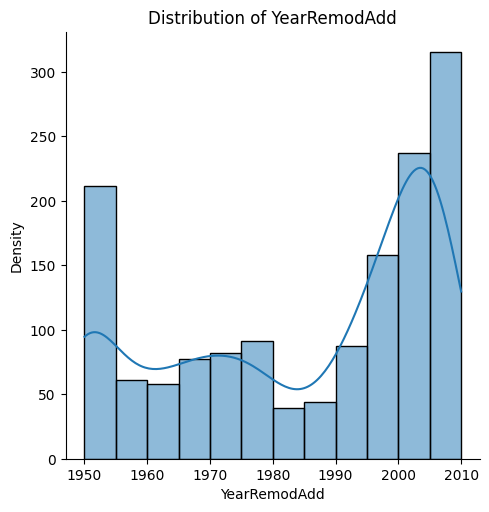

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

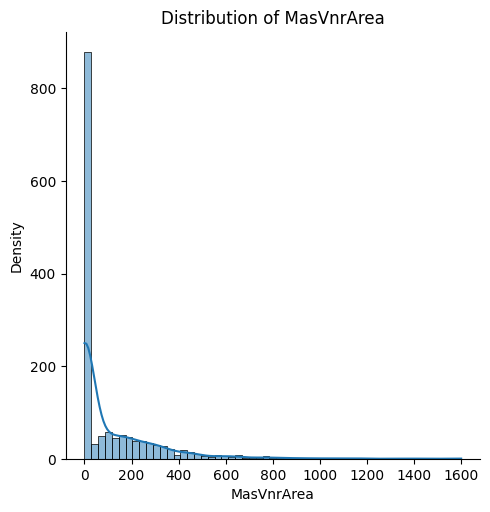

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

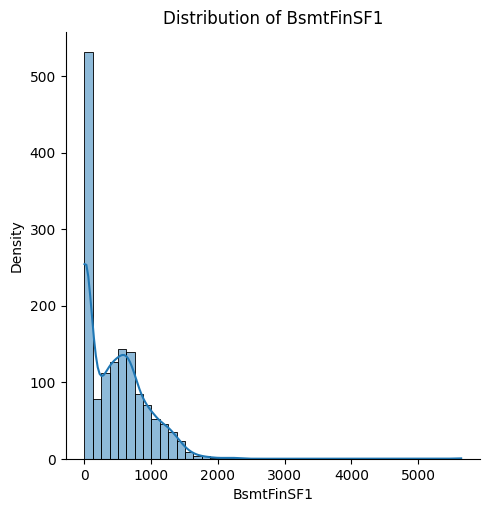

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

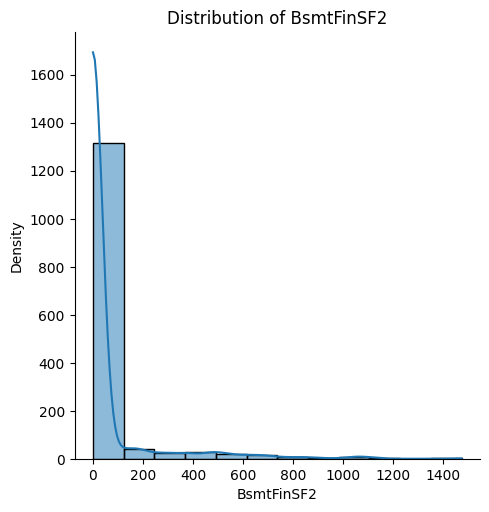

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

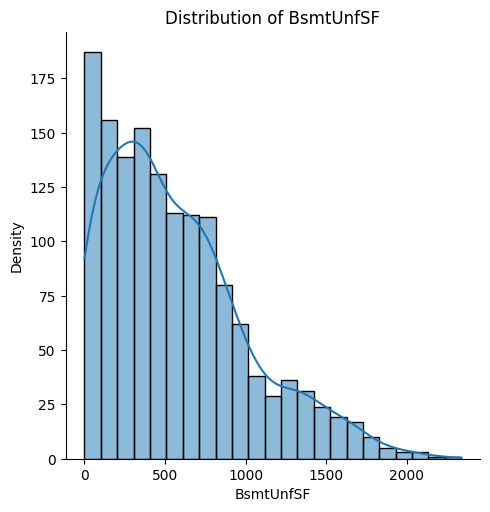

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

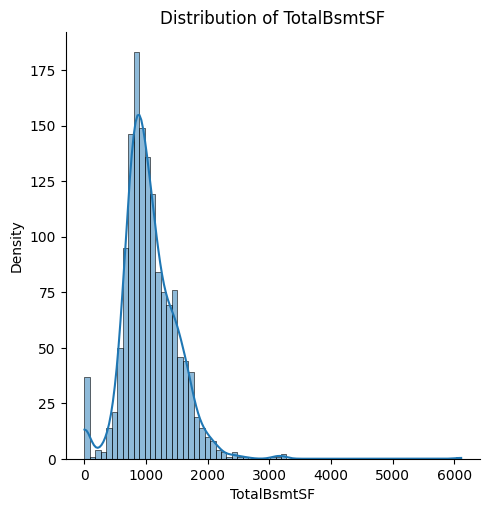

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

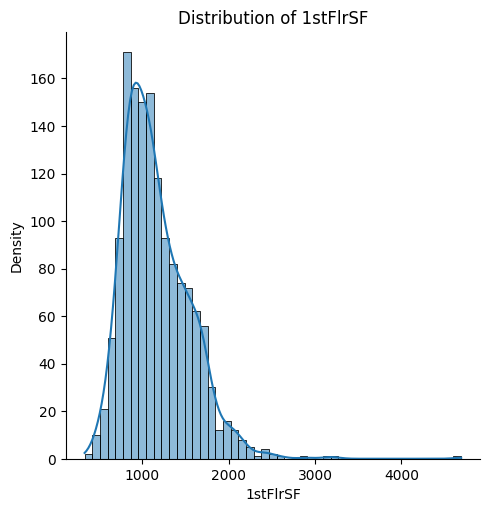

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

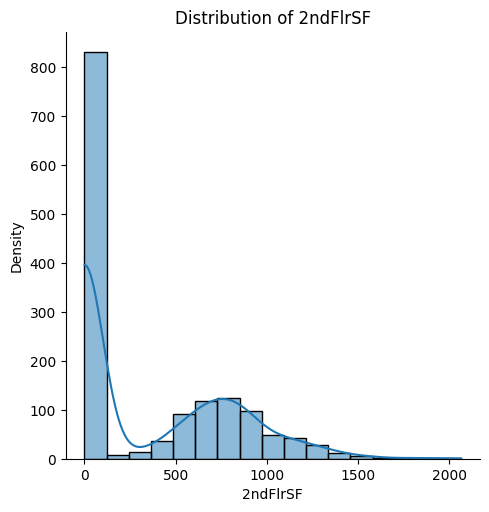

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

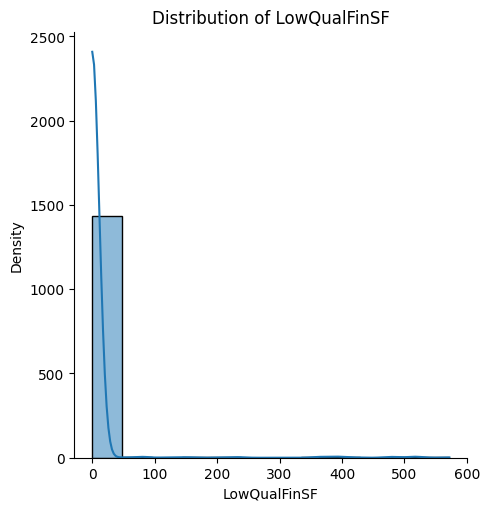

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

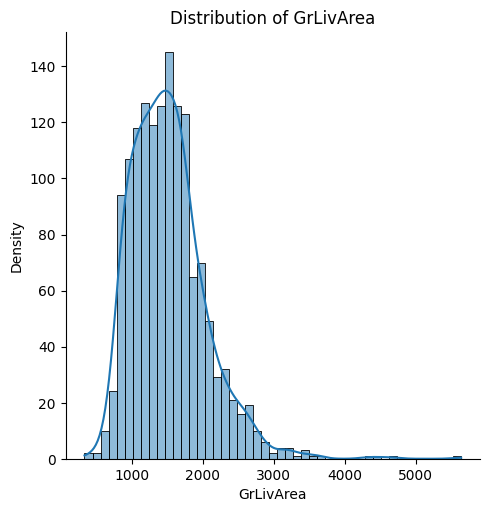

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

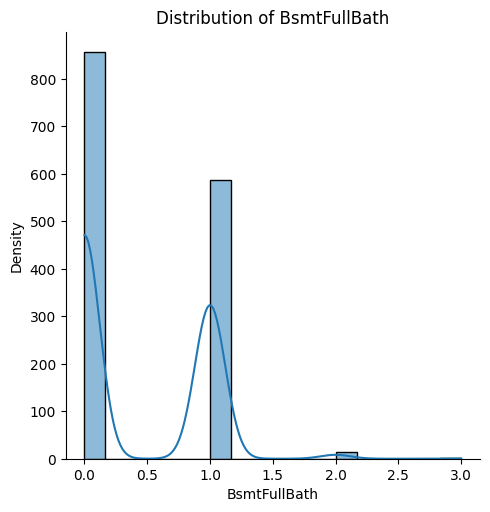

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

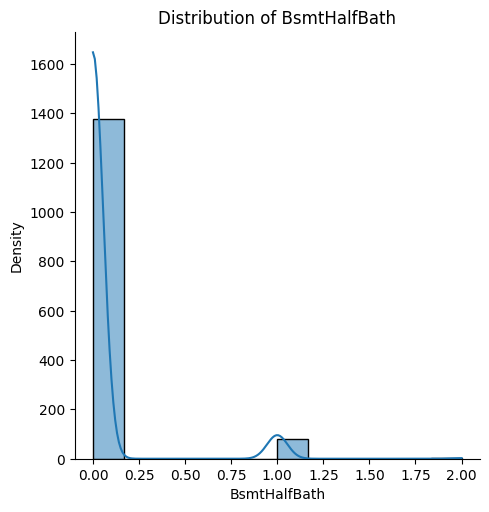

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

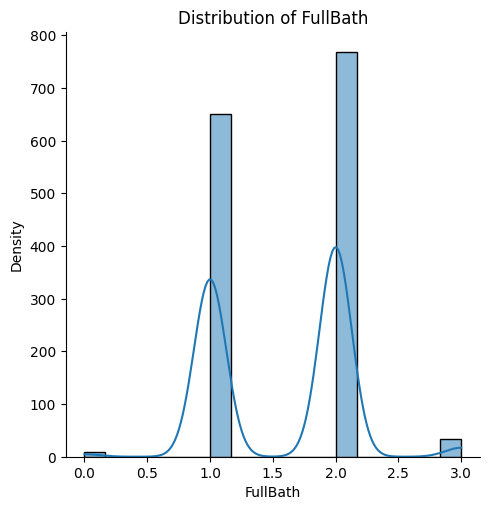

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

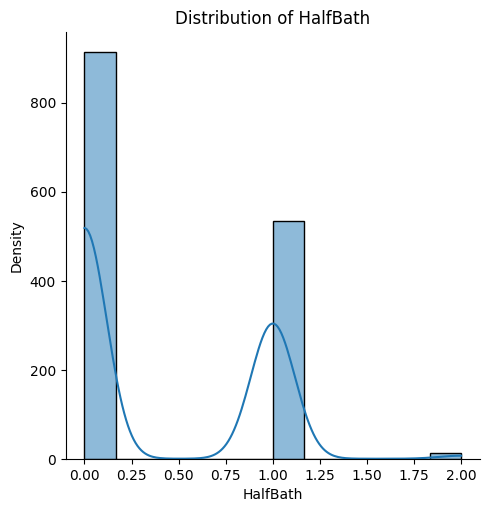

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

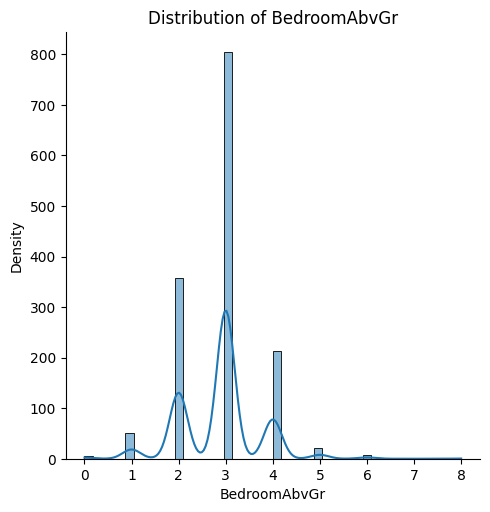

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

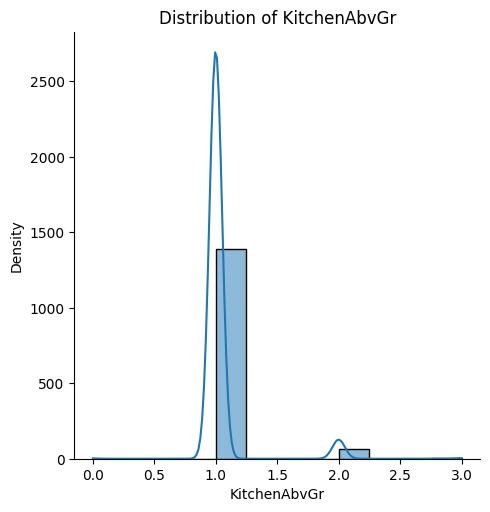

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

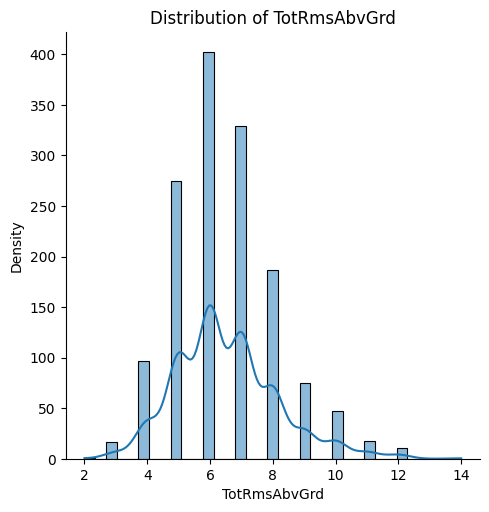

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

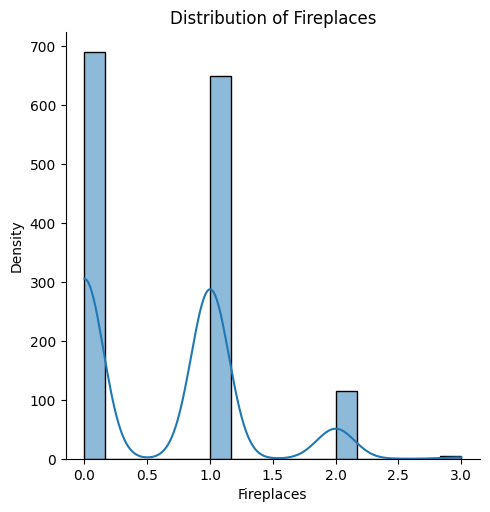

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

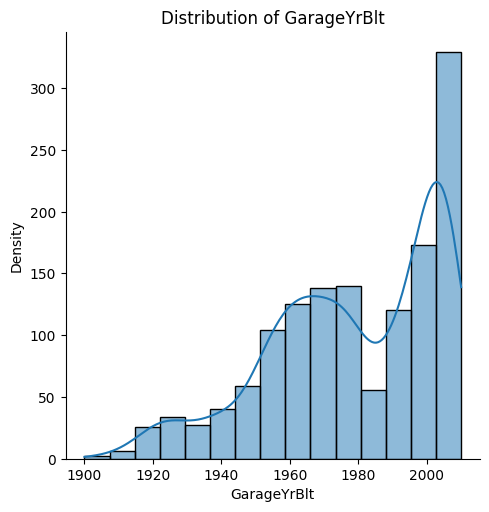

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

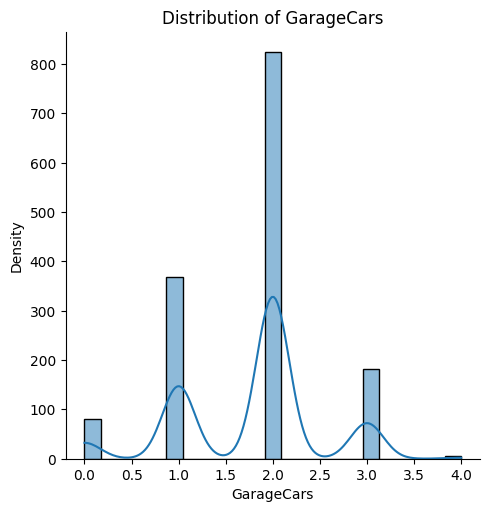

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

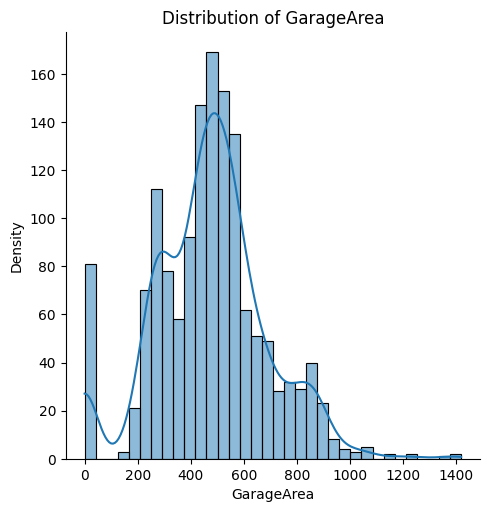

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

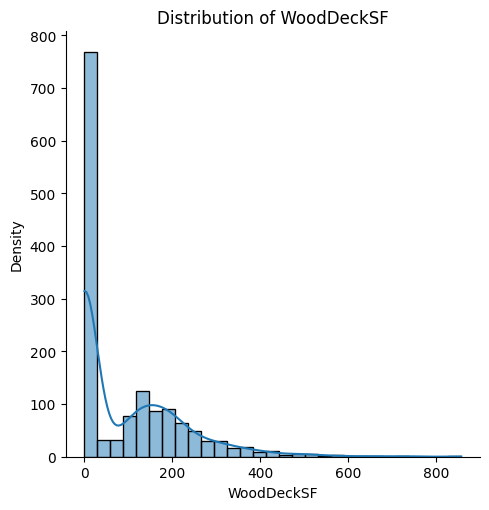

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

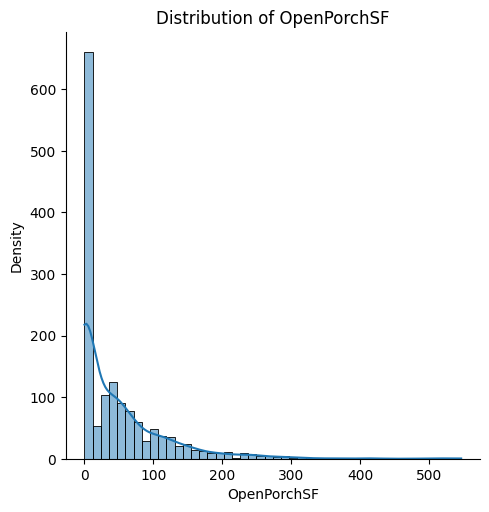

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

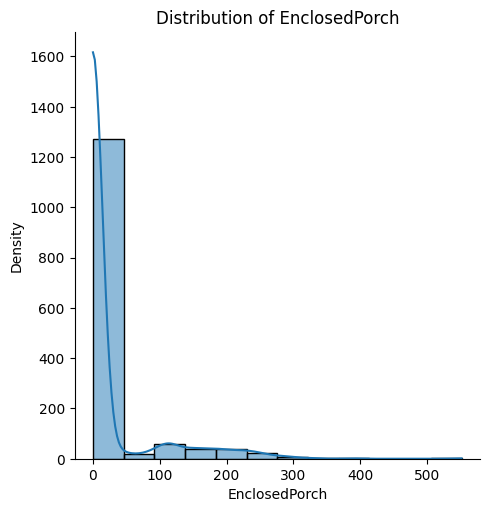

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

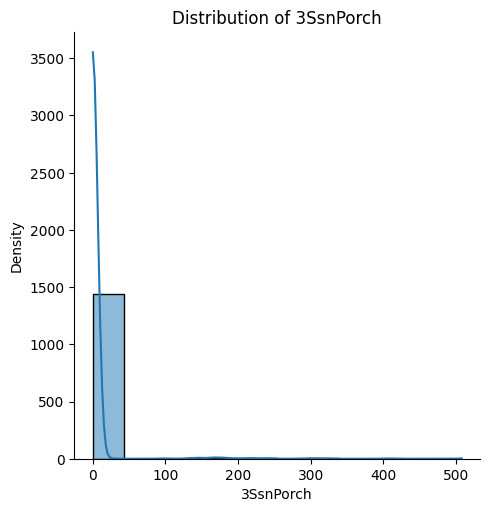

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

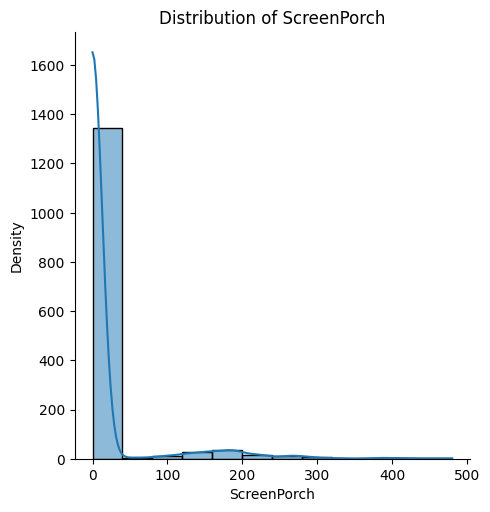

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

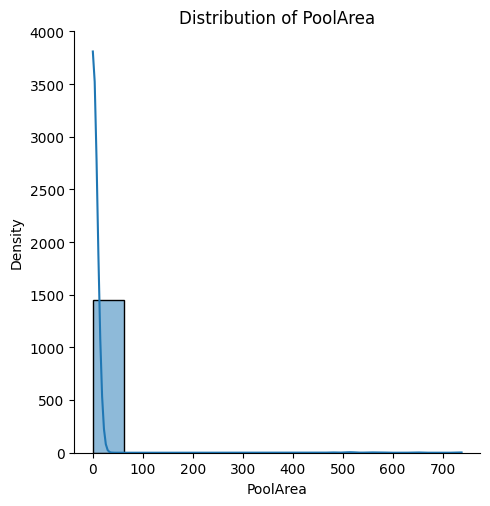

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

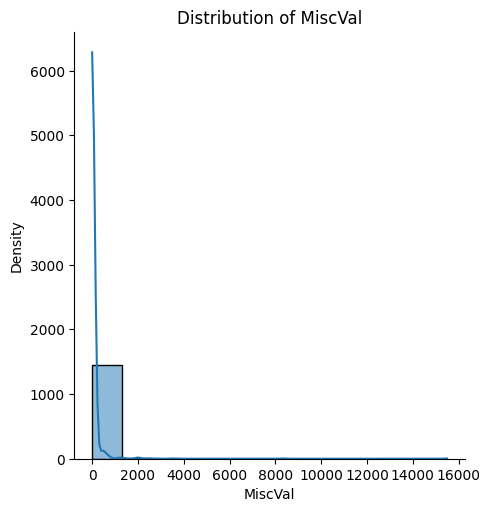

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

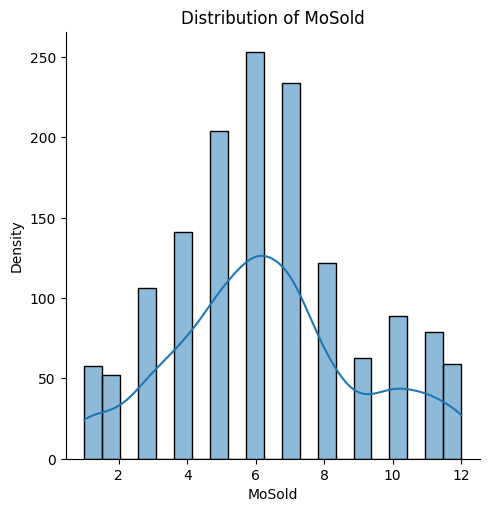

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

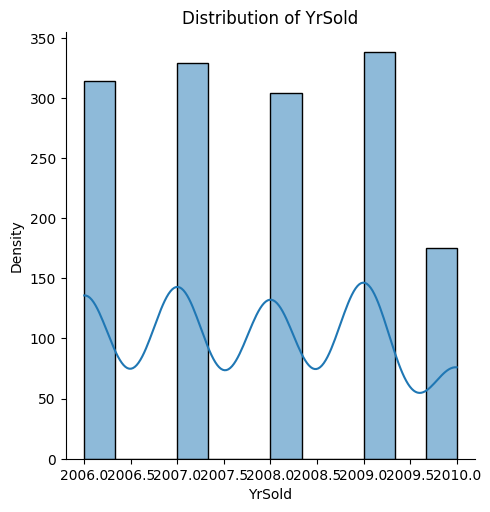

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x500 with 0 Axes>

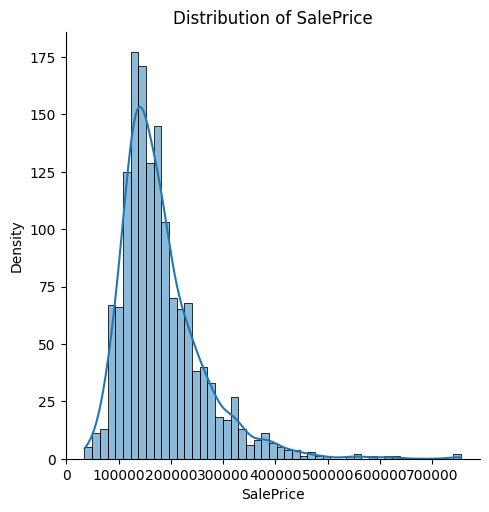

In [8]:
#plot displot for num_cols
for col in num_cols:
    plt.figure(figsize= (8,5))
    sns.displot(train[col],kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

In [9]:
#skewness for numerical column
for col in num_cols:
    skewness = train[col].skew()
    print(f"Skewness of column {col}:{skewness:.2f}")

Skewness of column Id:0.00
Skewness of column MSSubClass:1.41
Skewness of column LotFrontage:2.16
Skewness of column LotArea:12.21
Skewness of column OverallQual:0.22
Skewness of column OverallCond:0.69
Skewness of column YearBuilt:-0.61
Skewness of column YearRemodAdd:-0.50
Skewness of column MasVnrArea:2.67
Skewness of column BsmtFinSF1:1.69
Skewness of column BsmtFinSF2:4.26
Skewness of column BsmtUnfSF:0.92
Skewness of column TotalBsmtSF:1.52
Skewness of column 1stFlrSF:1.38
Skewness of column 2ndFlrSF:0.81
Skewness of column LowQualFinSF:9.01
Skewness of column GrLivArea:1.37
Skewness of column BsmtFullBath:0.60
Skewness of column BsmtHalfBath:4.10
Skewness of column FullBath:0.04
Skewness of column HalfBath:0.68
Skewness of column BedroomAbvGr:0.21
Skewness of column KitchenAbvGr:4.49
Skewness of column TotRmsAbvGrd:0.68
Skewness of column Fireplaces:0.65
Skewness of column GarageYrBlt:-0.65
Skewness of column GarageCars:-0.34
Skewness of column GarageArea:0.18
Skewness of column


Categorical 
MSSubClass,OverallQual, OverallCond


Discrete
BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, MoSold, YrSold,

Continuous
LotFrontage (Positively skewed),
 LotArea (Positively skewed), 
YearBuilt (Negatively skewed), 
YearRemodAdd (Bimodal Distribution-Negatively skewed)
MasVnrArea (Positively skewed), 
BsmtFinSF1 (Positively skewed),
BsmtFinSF2 (Positively skewed),
BsmtUnfSF  (Positively skewed),
TotalBsmtSF  (Positively skewed), 
1stFlrSF  (Positively skewed), 
2ndFlrSF  (Positively skewed), 
GrLivArea (Positively skewed), 
GarageYrBlt(negatively skew), 
GarageArea (normally distrubted), 
WoodDeckSF(positively skewed), 
OpenPorchSF (positively skewed), 
EnclosedPorch(positively skewed), 
3SsnPorch, 
ScreenPorch (positively skewed),
 PoolArea, 
MiscVal,
 SalePrice (positively skewed)



**Bivariate EDA**

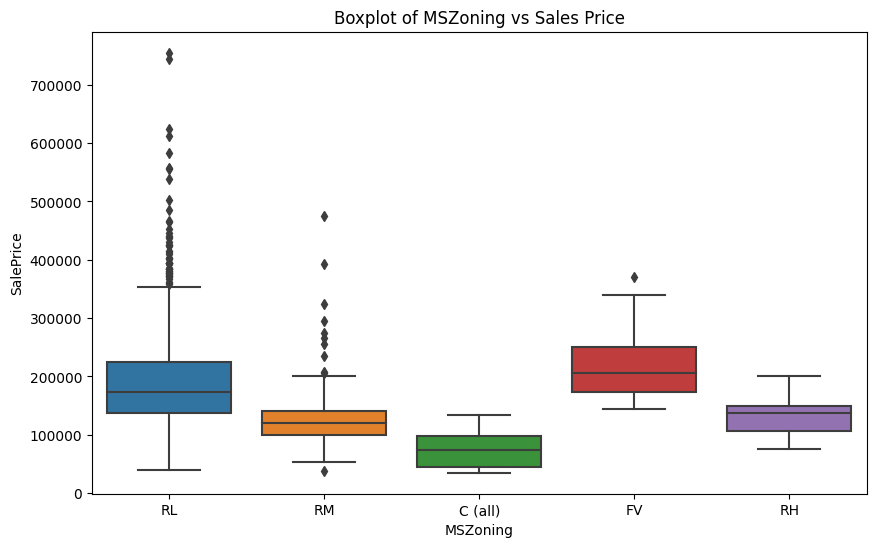

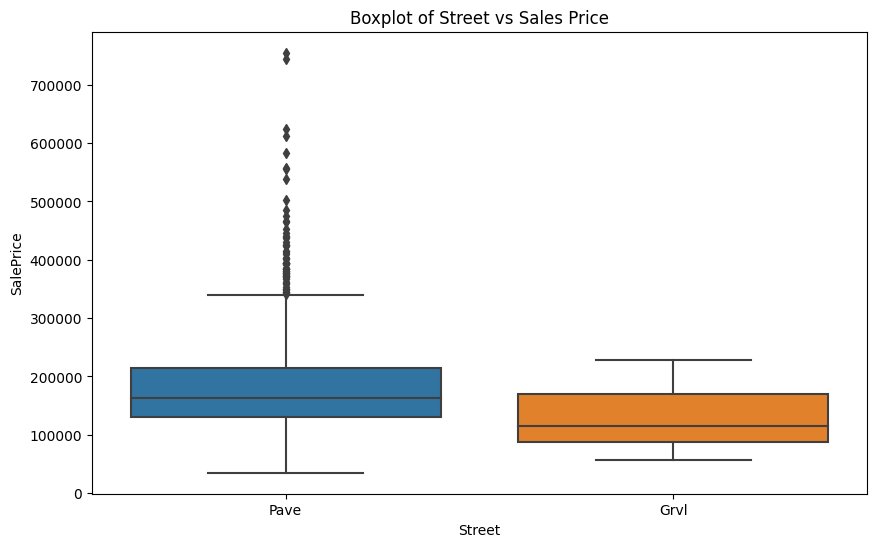

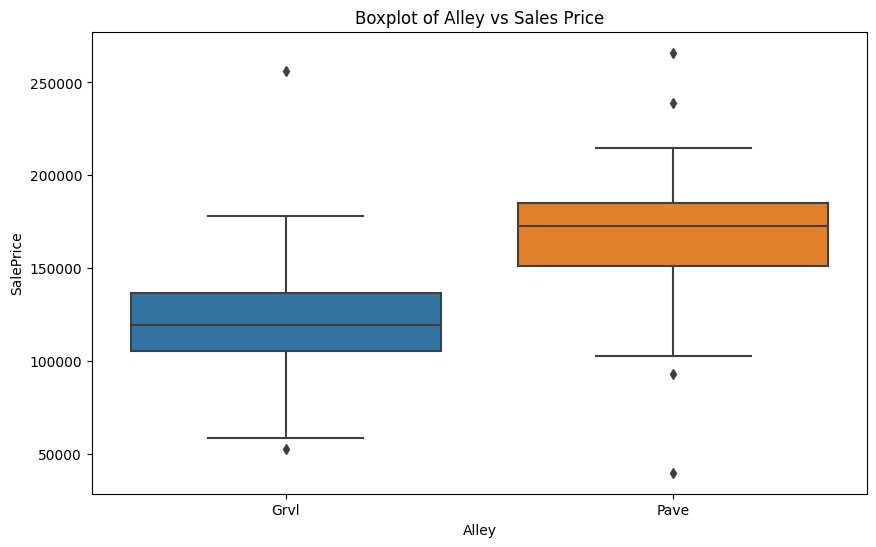

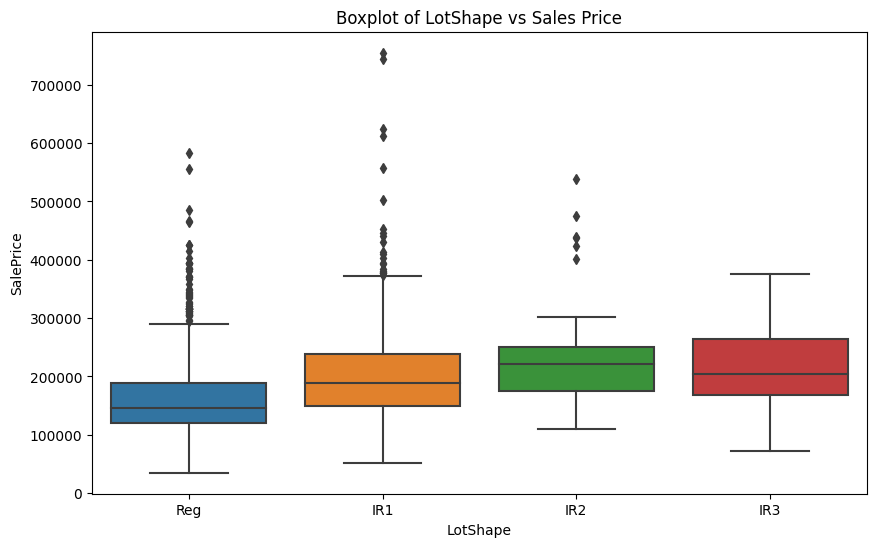

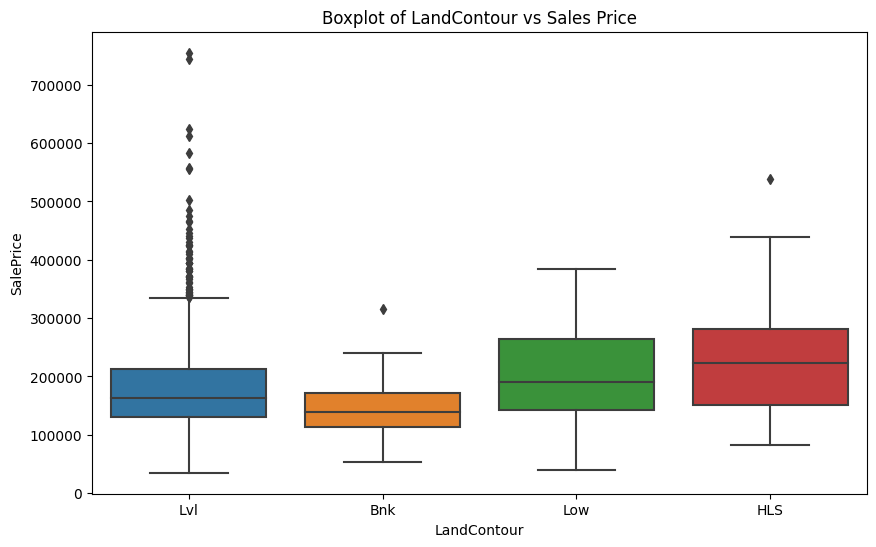

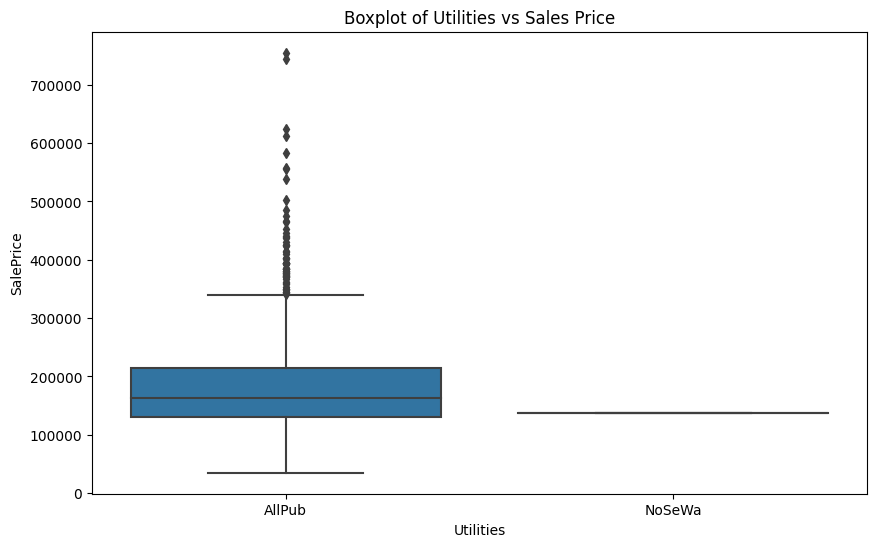

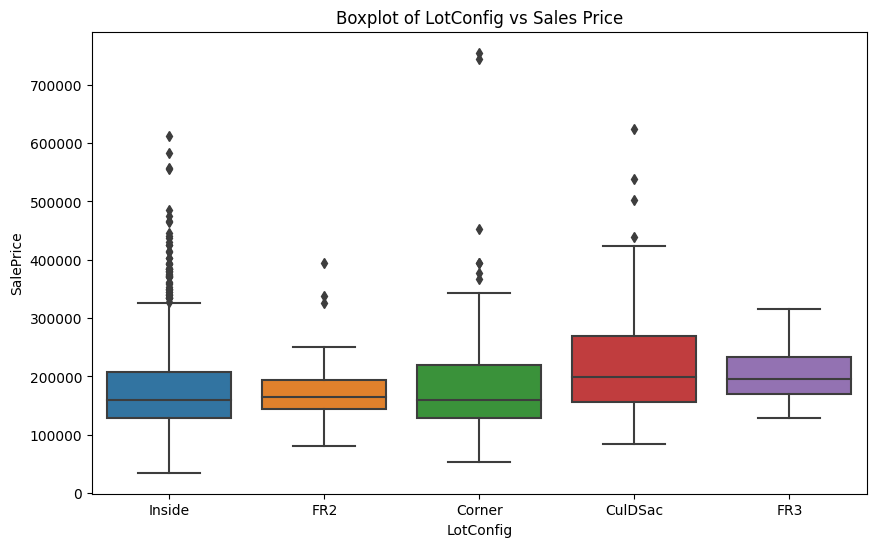

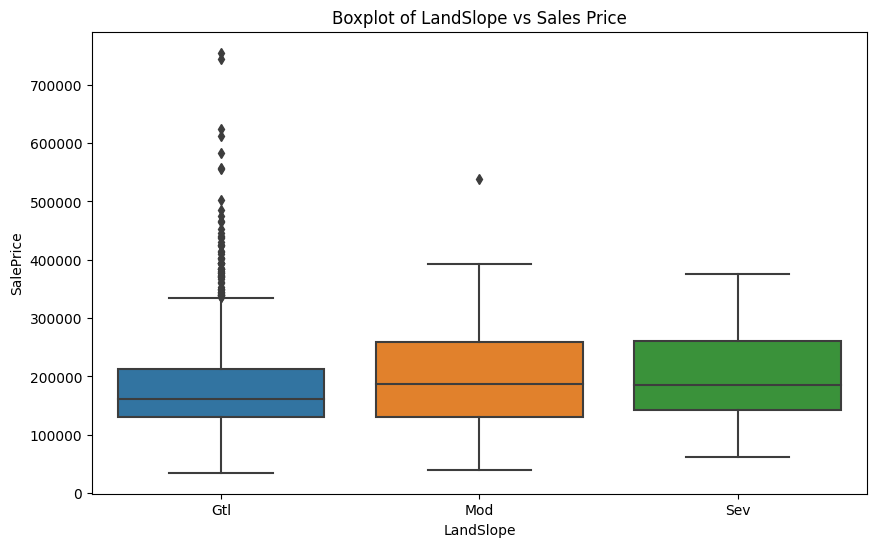

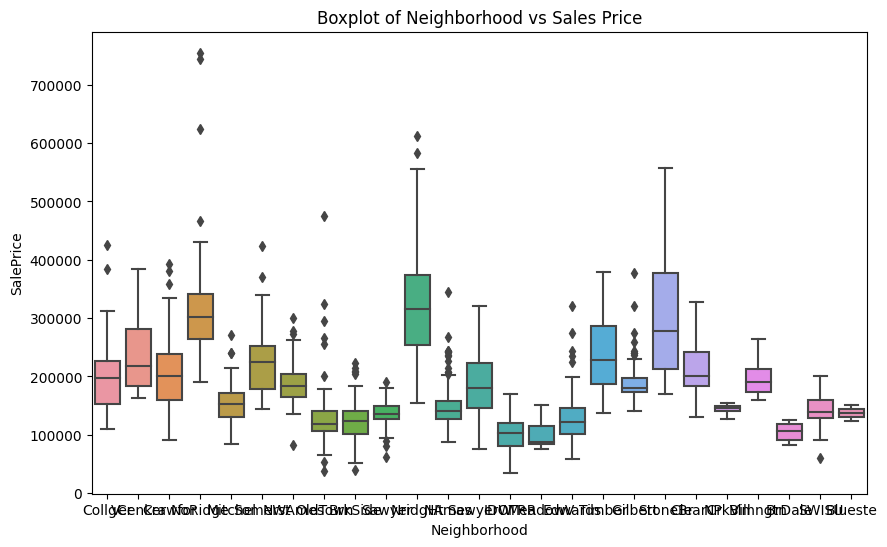

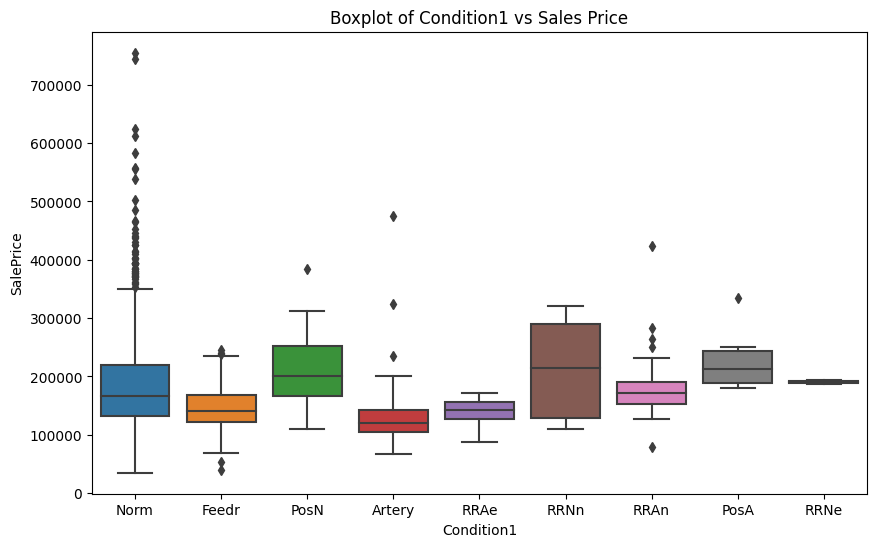

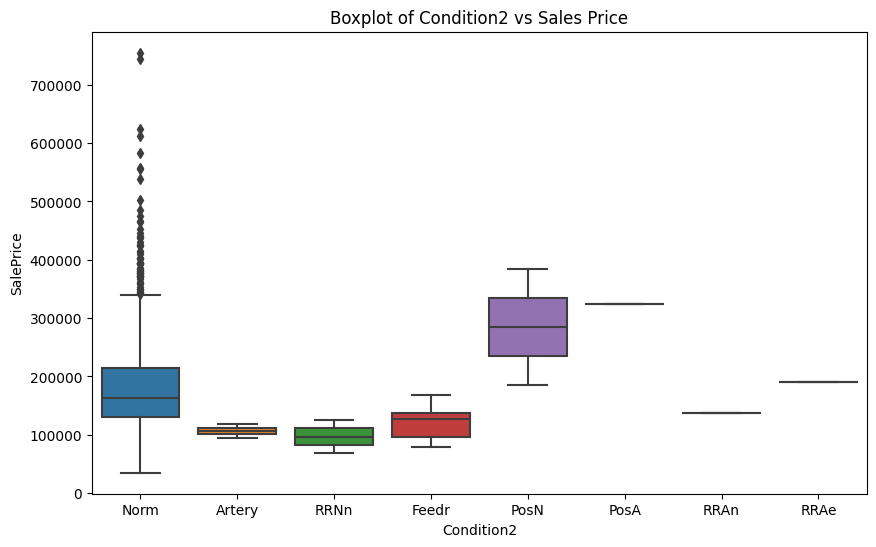

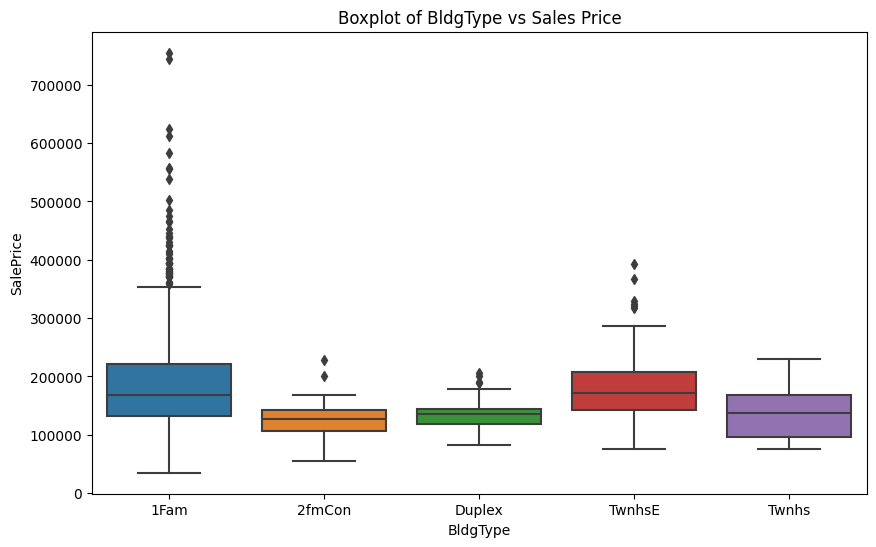

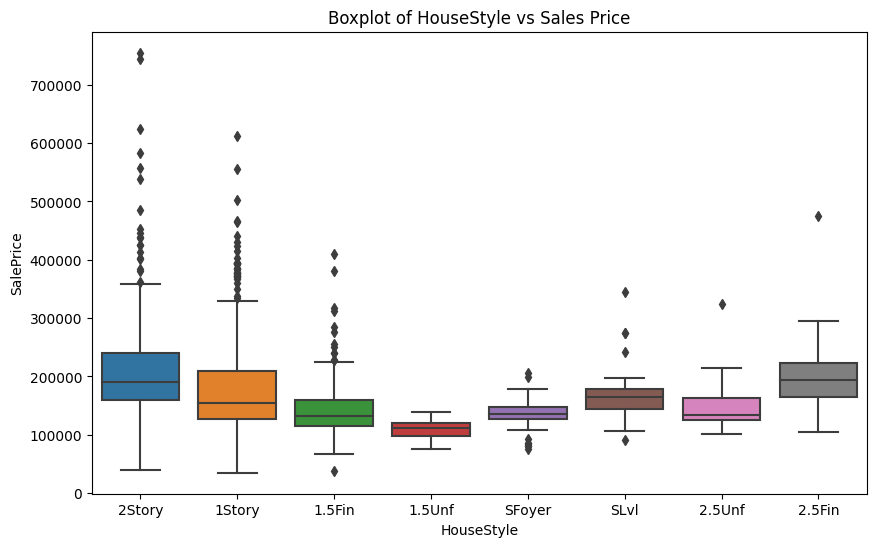

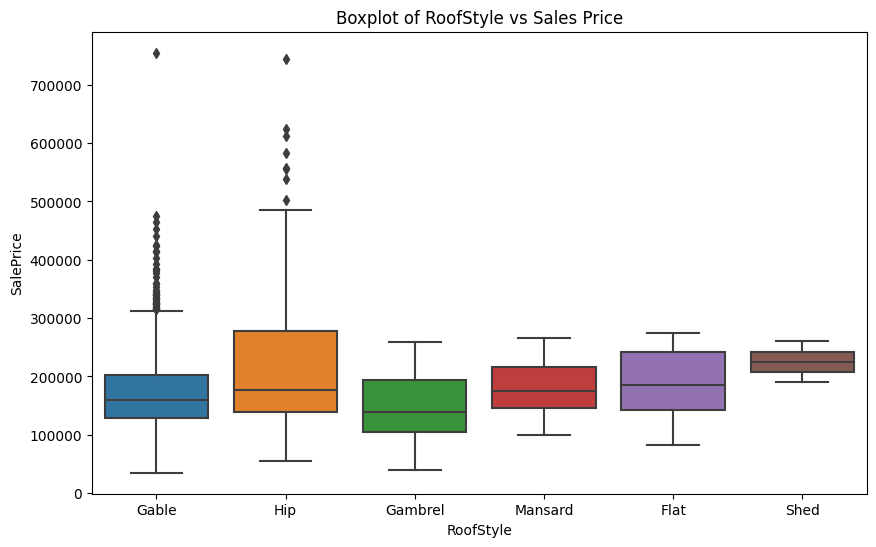

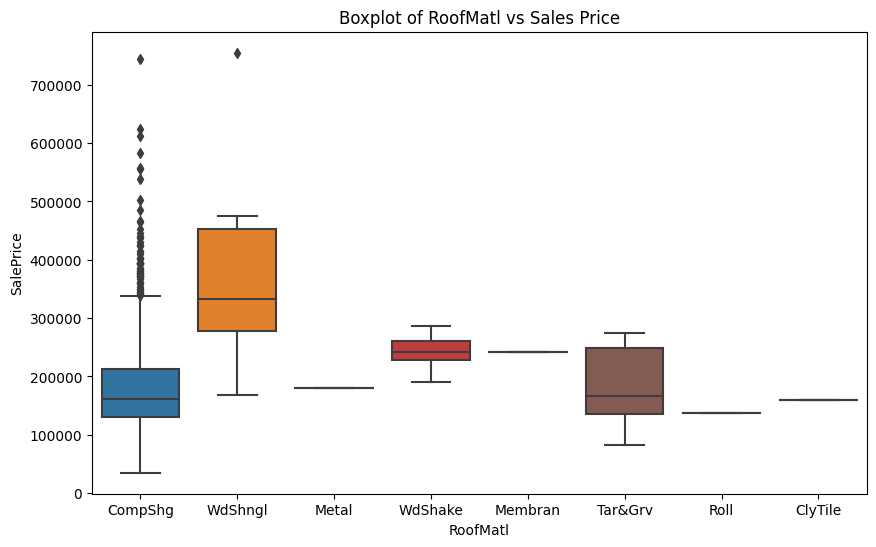

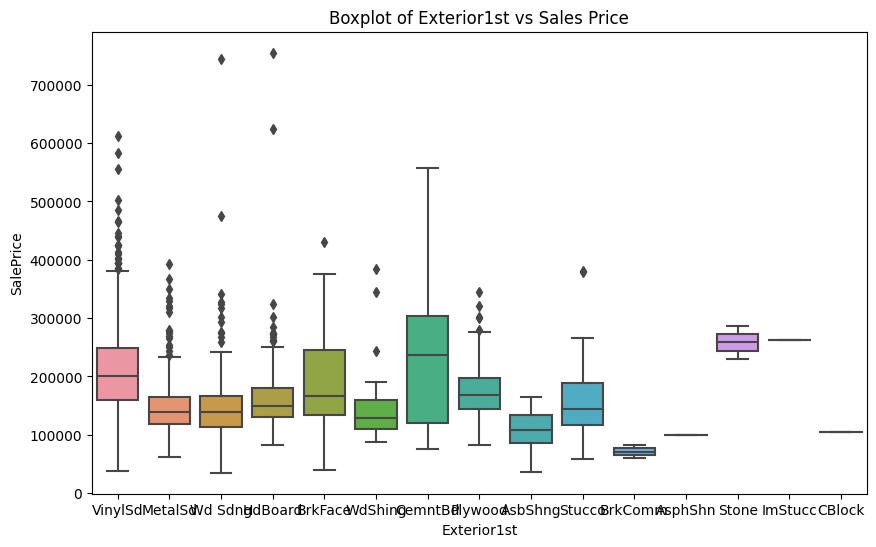

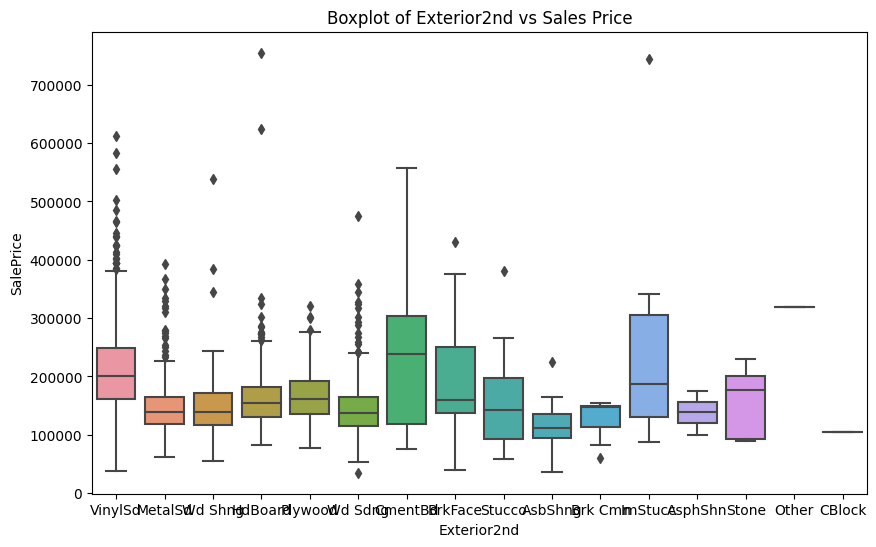

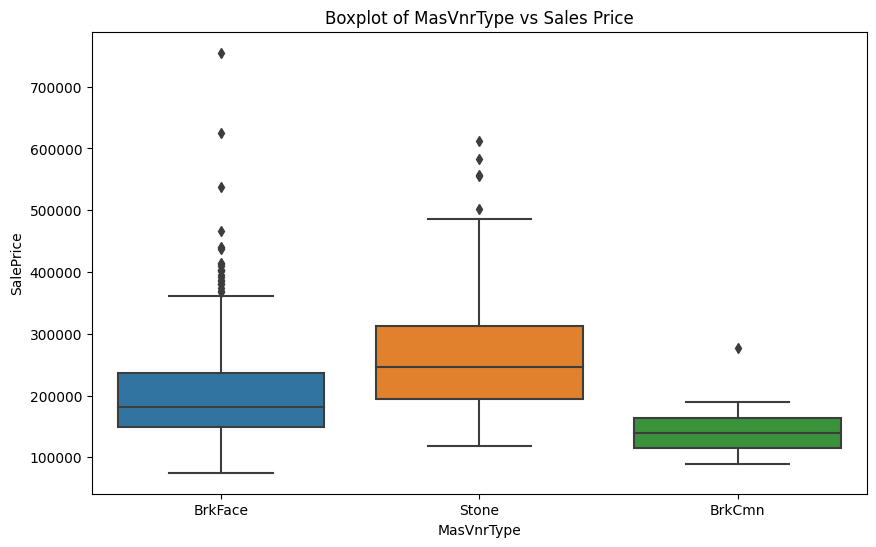

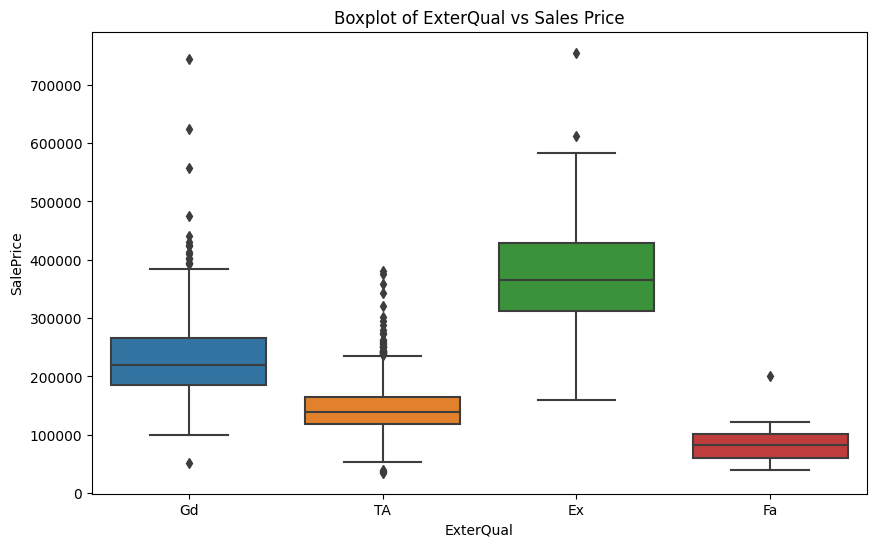

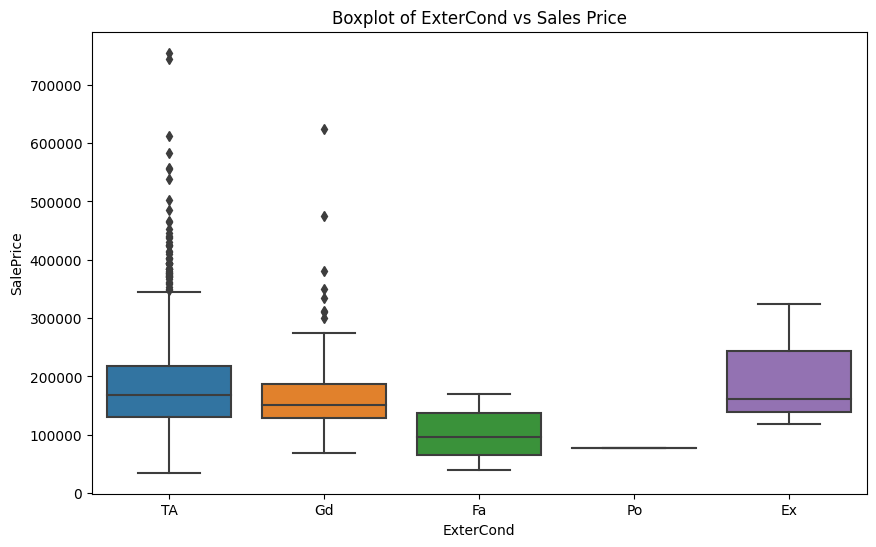

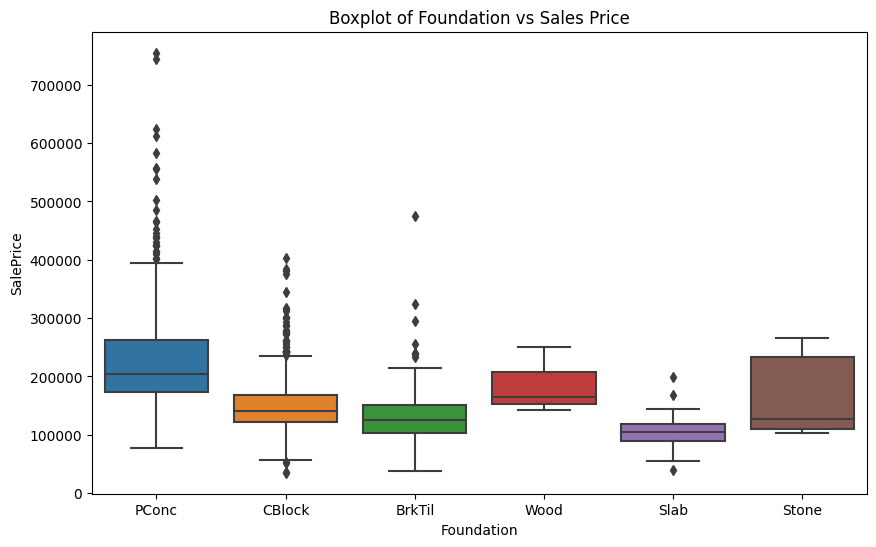

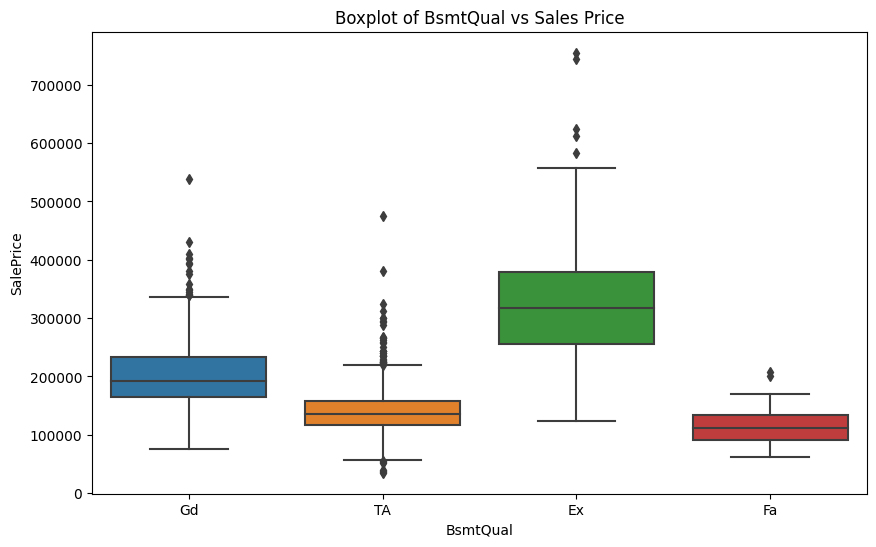

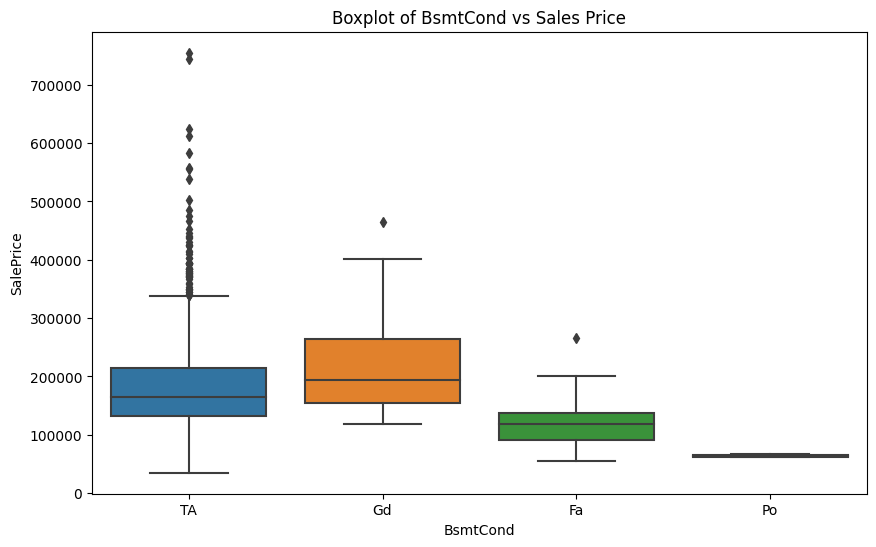

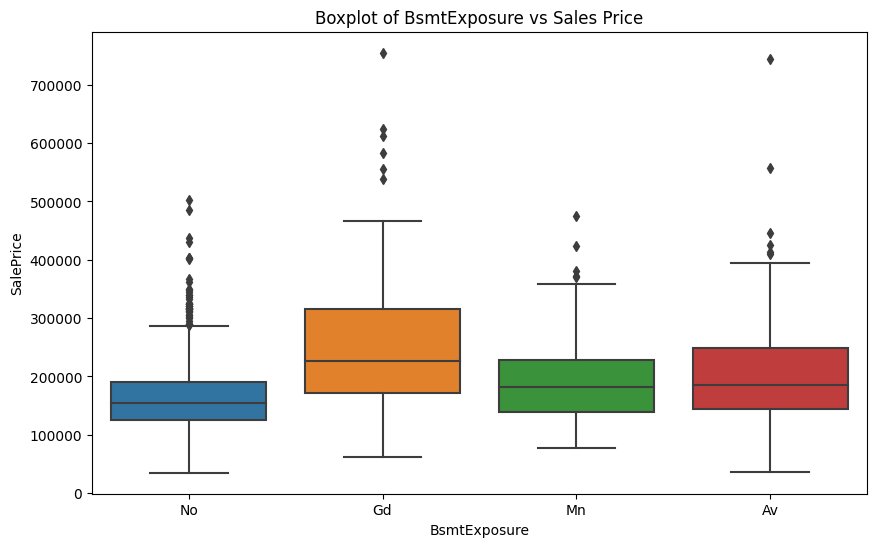

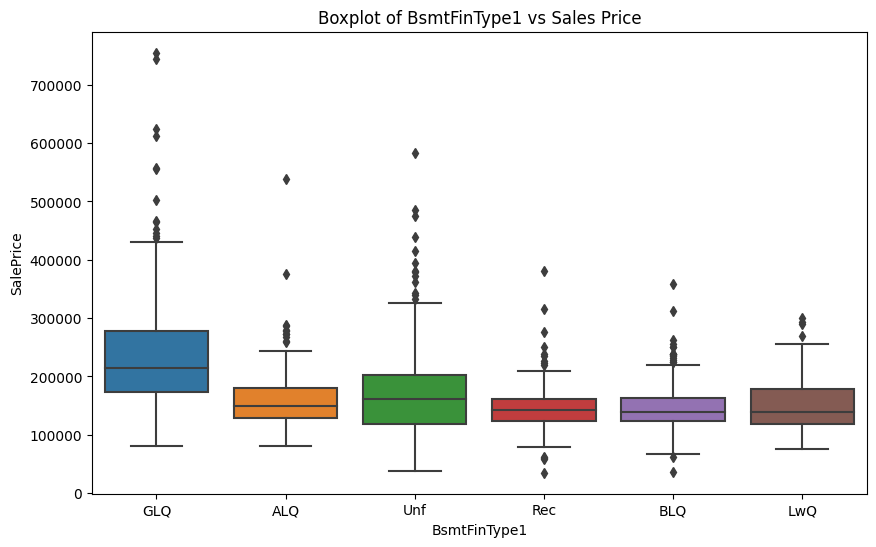

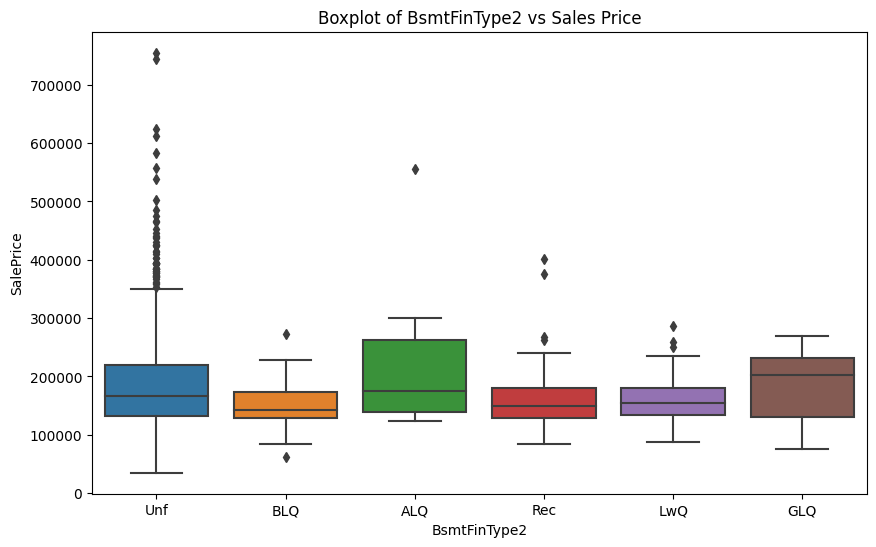

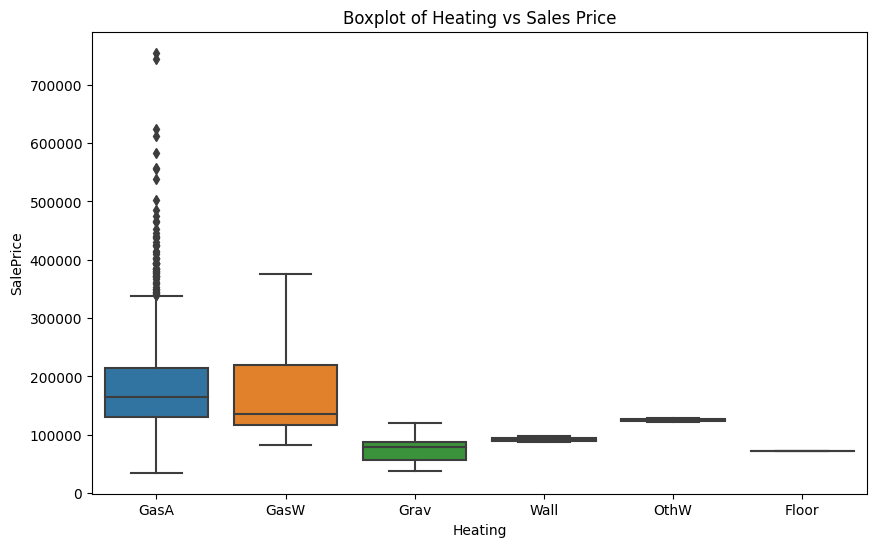

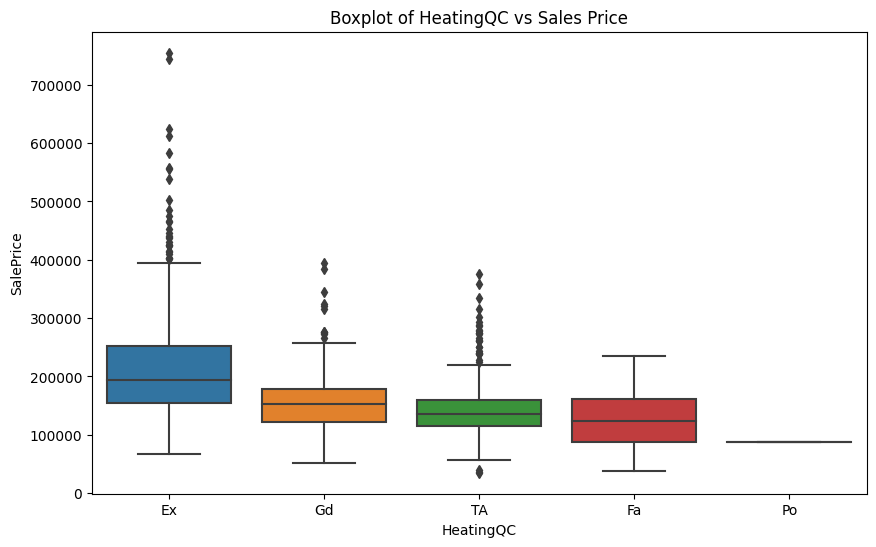

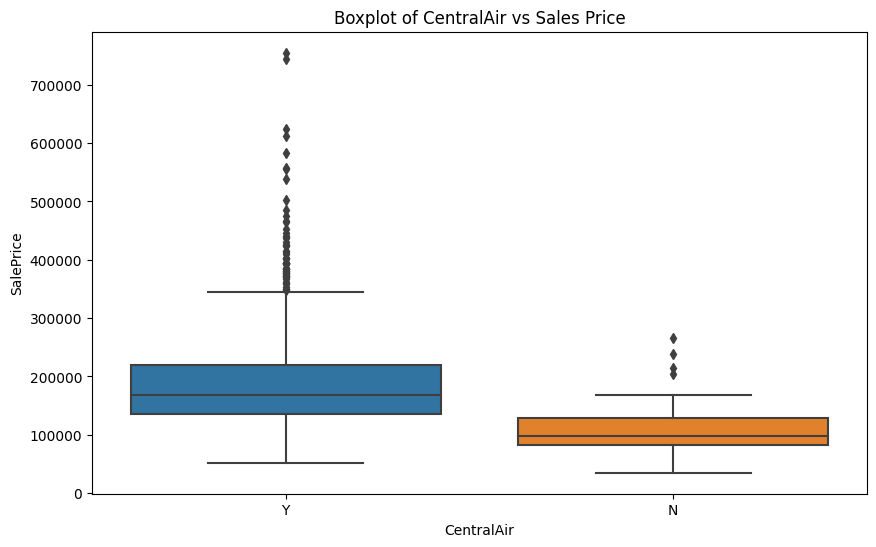

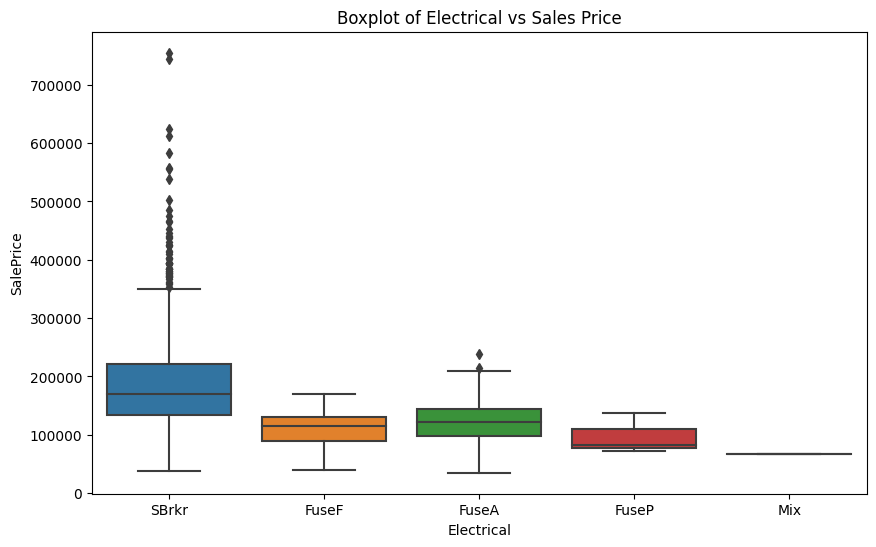

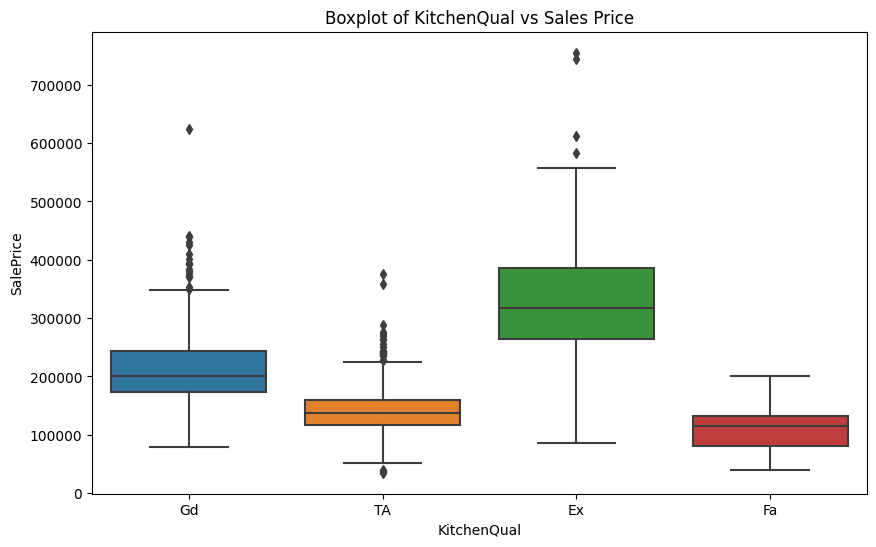

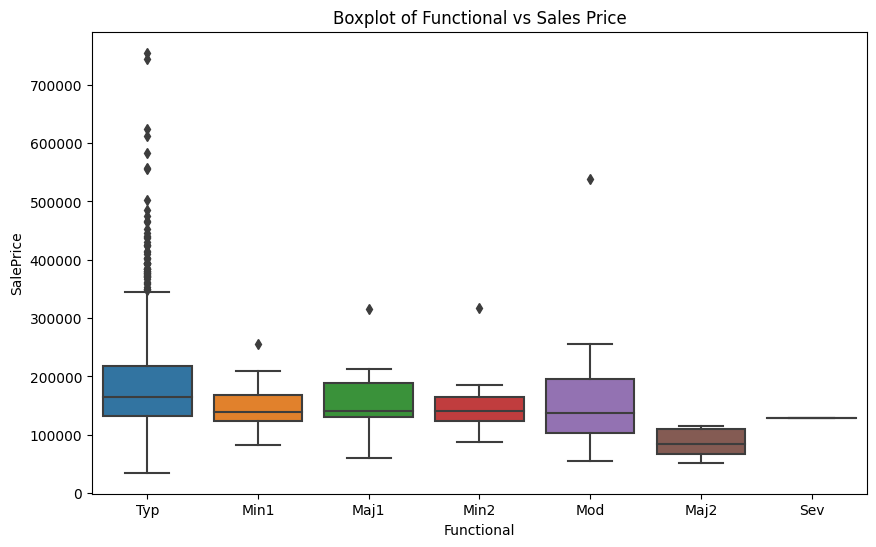

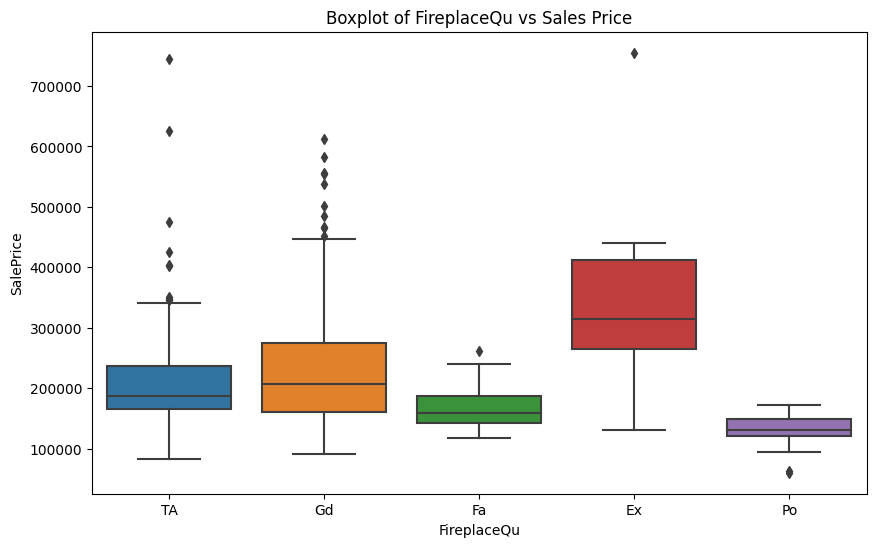

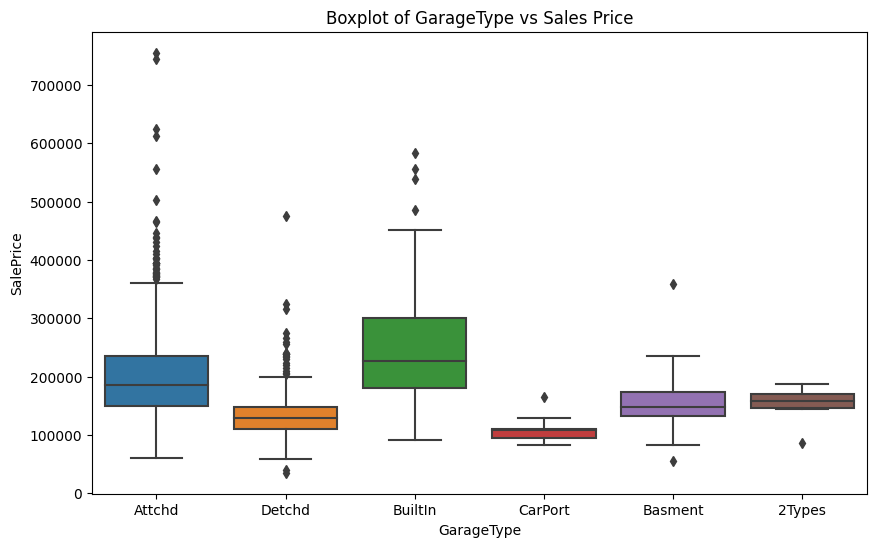

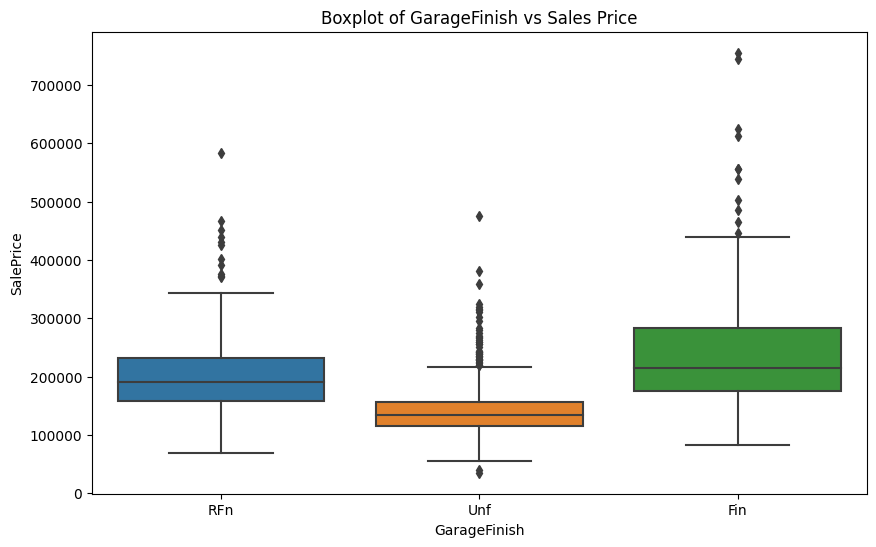

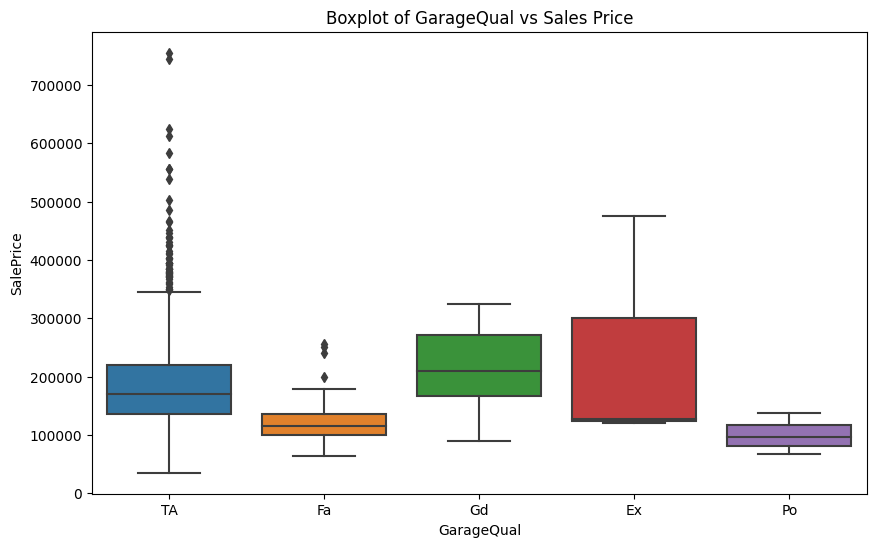

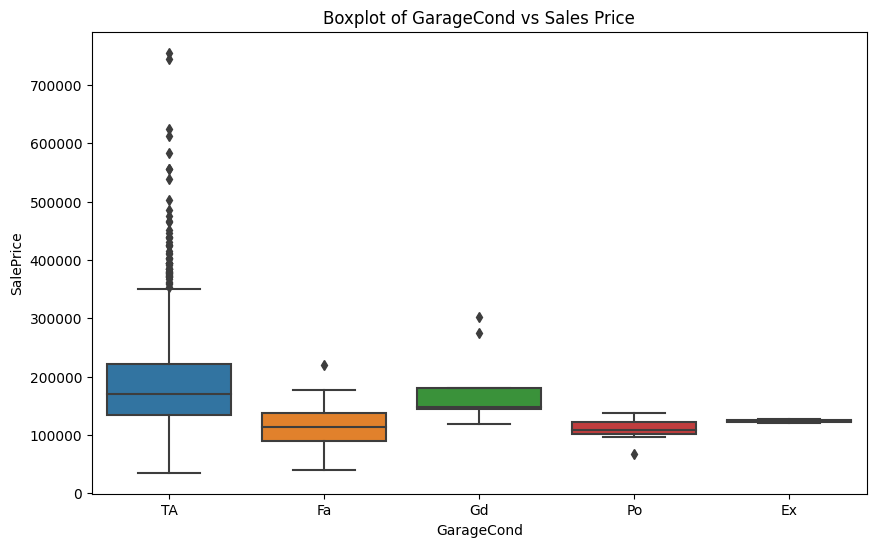

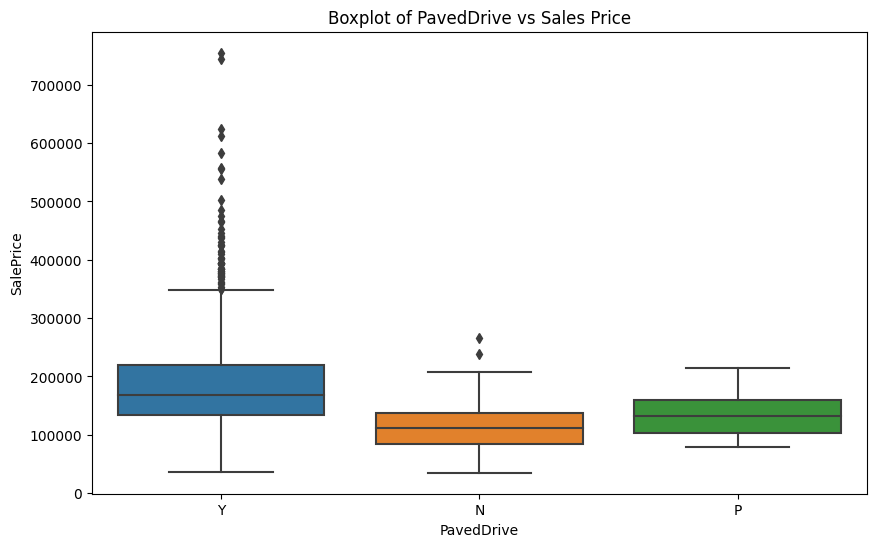

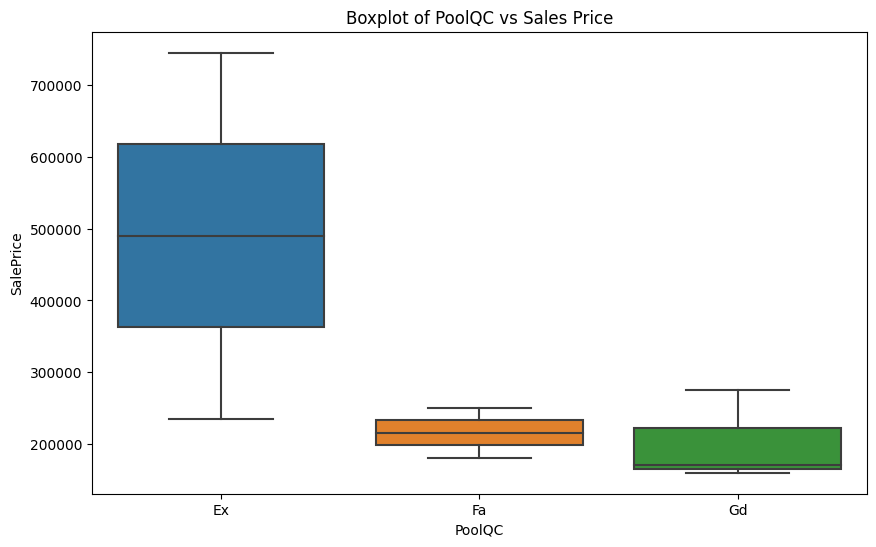

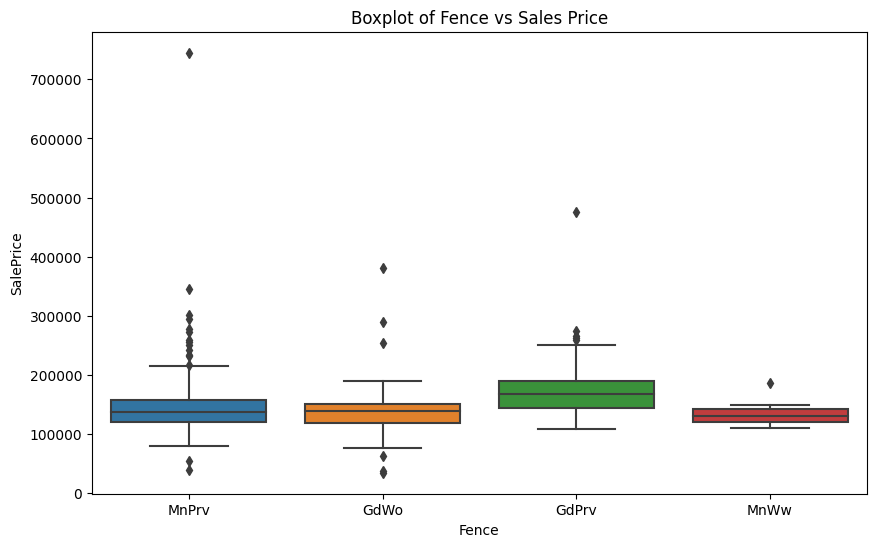

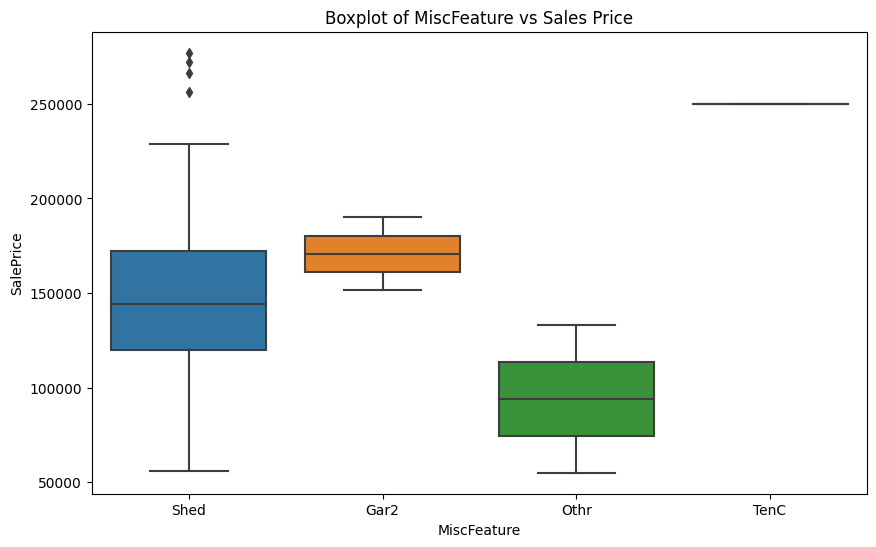

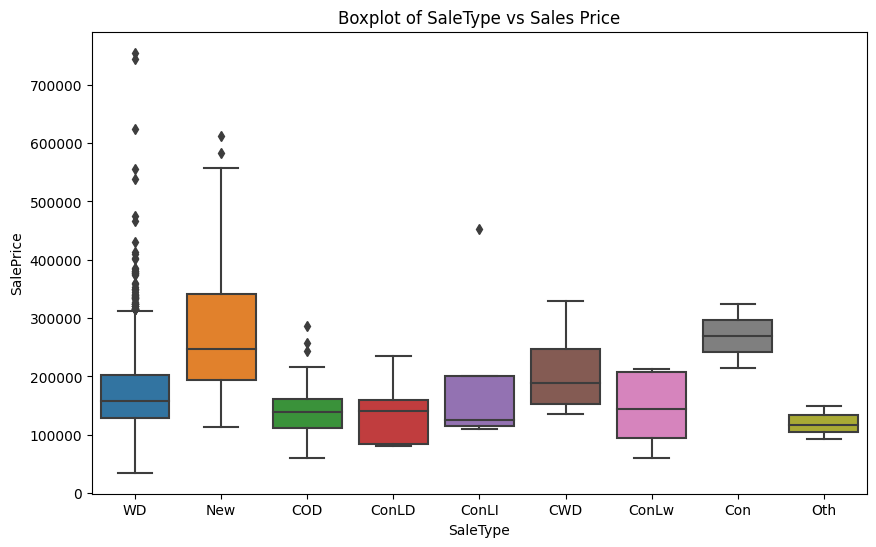

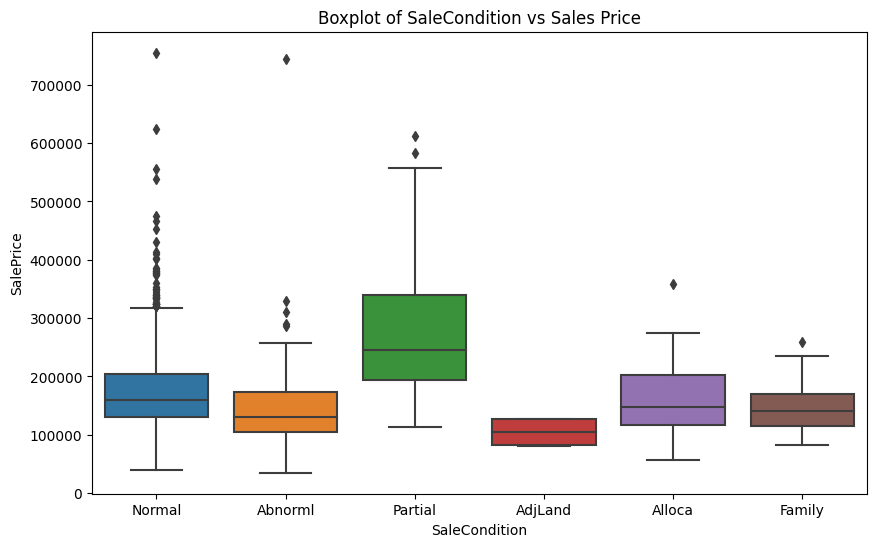

In [10]:
#Correlation of categorical variables with Sales Price
for col in cat_cols:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=col, y='SalePrice', data=train)
    plt.title(f"Boxplot of {col} vs Sales Price")
    plt.show()

The boxplot analysis reveals notable variations in housing sale prices across different categories. RL (Residential Low Density) exhibits the widest range of sale prices, while C (Commercial) has the lowest and FV (Floating Village Residential) the highest median sale prices. Paved road and alley access are linked to higher median prices than gravel access. Lot configurations like CulDSac and FR2 display differing price distributions, with CulDSac having a larger range.

For conditions, houses near arterial streets have the lowest median prices, while proximity to railroads or positive off-site features shows mixed results in price variation. Building types show similarity in medians, but 1Fam homes have a wider price distribution. Roof and masonry materials, like wood shingles and stone veneer, are linked to higher sale prices.

Quality-related factors (e.g., ExterQual, KitchenQual, and BsmtQual) significantly impact prices, with excellent ratings consistently driving higher medians. Similarly, homes with central air, paved driveways, and excellent heating or garage quality achieve higher prices. The presence of sheds, pool quality, and fireplace conditions also influence price ranges.

In sale type and condition, newly constructed homes and houses assessed as incomplete show the widest price ranges. Overall, factors like quality, access, and materials contribute significantly to housing price variability.








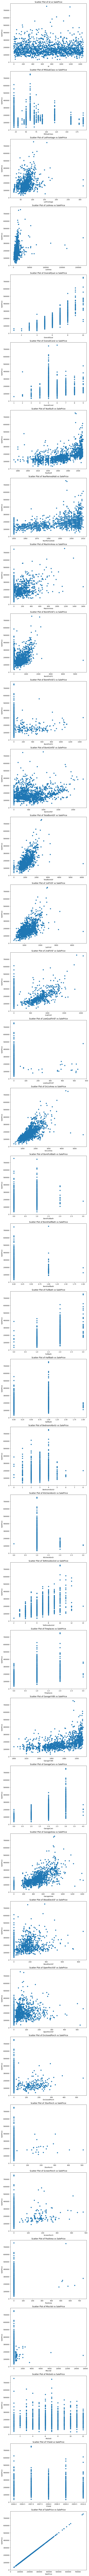

In [11]:
#Correlation of numerical variables with Sales Price


# Create a figure and axis object
fig, ax = plt.subplots(len(num_cols), 1, figsize=(8, 6*len(num_cols)))

# Iterate over numerical columns and plot scatter plots
for i, col in enumerate(num_cols):
    ax[i].scatter(train[col], train['SalePrice'])
    ax[i].set_title(f'Scatter Plot of {col} vs SalePrice')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('SalePrice')

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()


The scatter plot analysis shows a **positive** correlation between sale price and several features. LotFrontage, LotArea, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, GarageYrBlt, GarageArea, and OpenPorchSF exhibit a **stronger** positive correlation with sale price, indicating that as these features increase, the sale price tends to increase as well. Additionally, some features such as YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, WoodDeckSF, and EnclosedPorch show a **weak** positive correlation, meaning that the relationship exists but is not as pronounced. The remaining features show n**o significant correlation** with sale price, implying little or no relationship between these variables

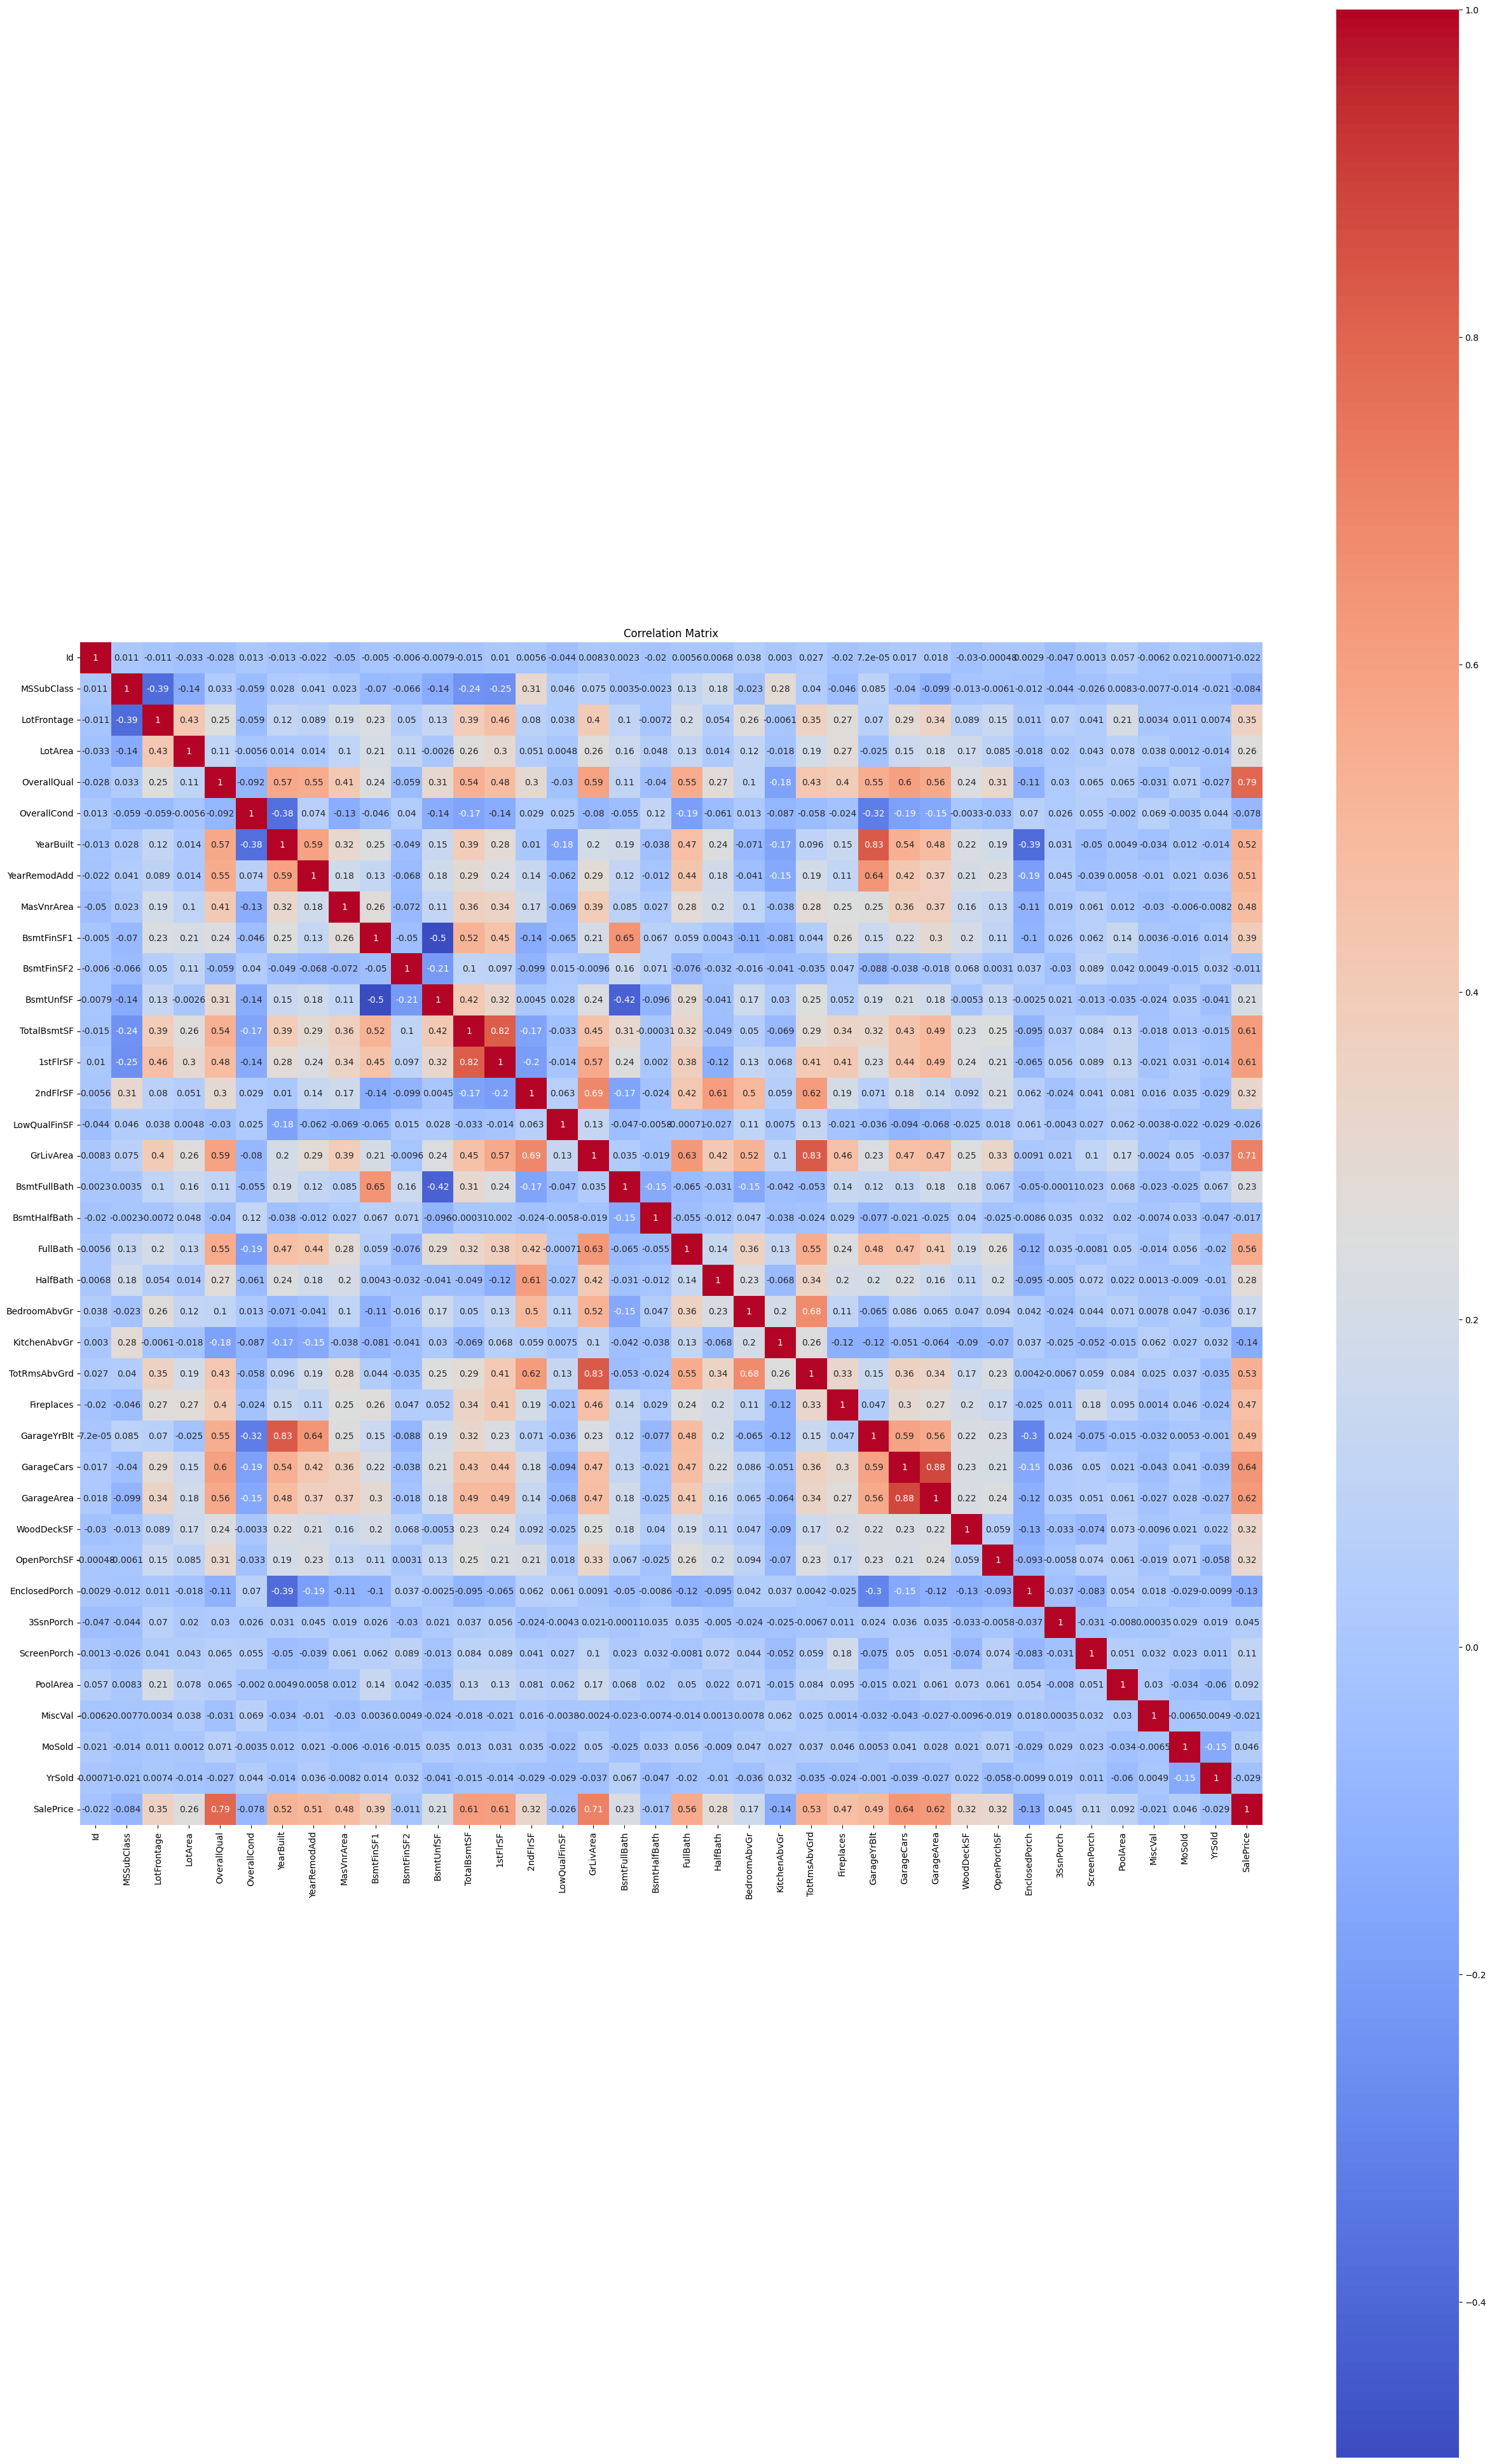

In [12]:
#correlation matrix
corr_matrix = train[num_cols].corr()

#create heatmap
plt.figure(figsize=(30,50))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',square=True)

#Set title
plt.title('Correlation Matrix')

#Show the plot
plt.show()

The variable OverallQual has the highest correlation with SalePrice, indicating a strong relationship between the two. On the other hand, BsmtFinSF2 has the weakest correlation with SalePrice.Some strong correlations are also observed between other feature: TotRmsAbvGr has a strong correlation with GrLivArea(0.83), GarageYrBlt is highly correlated with YearBuilt(0.83), GarageArea and GarageCars are strongly correlated(0.88), and 1stFlrSF has strong relationship with TotalBsmtSF(0.82).

# Data Manipulation

In [13]:
#Remove columns
train=train.drop(columns=['Id','BsmtFinSF2','GarageYrBlt','1stFlrSF','GrLivArea'])

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [15]:
#missing data
total=train.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total,percent], axis=1, keys=['Total','Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
MasVnrType      872  0.597260
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageQual       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
MasVnrArea        8  0.005479
Electrical        1  0.000685
Fireplaces        0  0.000000
MSSubClass        0  0.000000

* Remove columns when percentage > 0.15
* Delete variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu'which are strong candidates for outliers
* 'GarageX‘ variables have same amounts of missing data. Since GarageCar variable is related to GarageX,have no missing data and represent most important information regarding garages,GarageX variables are removed. Same logic applies to 'BsmtX' variables
* Remove MasVnrArea' and 'MasVnrType' as they are not essential and have strong correlation with 'YearBuilt' and 'OverallQual'
* Only keep 'Electrical', the missing data will be deleted



In [16]:
# Extract column names where Total > 1
columns_to_drop = missing_data[missing_data['Total'] > 1].index.tolist()

print(columns_to_drop)

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'LotFrontage', 'GarageCond', 'GarageQual', 'GarageType', 'GarageFinish', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond', 'MasVnrArea']


In [17]:
# Dealing with missing data
train = train.drop(index=train.loc[train['Electrical'].isnull()].index, axis=0)  # Drop rows with missing 'Electrical' data
train = train.drop(columns=columns_to_drop)

# Check for any remaining missing data
missing_count = train.isnull().sum().max()  # Check if there's any missing data left
print(f'Max missing data count in any column: {missing_count}')

Max missing data count in any column: 0


In [18]:
train['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

### Outliers

In [19]:
#Scale Price
scaler = StandardScaler()
train['ScaledSalePrice'] = scaler.fit_transform(train[['SalePrice']])

# Extract records
top_10_highest = train.nlargest(10, 'SalePrice')
top_10_lowest = train.nsmallest(10, 'SalePrice')


print("Top 10 Highest Sale Prices:")
print(top_10_highest[['SalePrice', 'ScaledSalePrice']])
print("\nTop 10 Lowest Sale Prices:")
print(top_10_lowest[['SalePrice', 'ScaledSalePrice']])

Top 10 Highest Sale Prices:
      SalePrice  ScaledSalePrice
691      755000         7.226298
1182     745000         7.100420
1169     625000         5.589879
898      611657         5.421919
803      582933         5.060346
1046     556581         4.728631
440      555000         4.708730
769      538000         4.494736
178      501837         4.039522
798      485000         3.827581

Top 10 Lowest Sale Prices:
      SalePrice  ScaledSalePrice
495       34900        -1.838208
916       35311        -1.833034
968       37900        -1.800444
533       39300        -1.782821
30        40000        -1.774010
710       52000        -1.622956
1337      52500        -1.616662
705       55000        -1.585192
1325      55000        -1.585192
812       55993        -1.572692


The **low** outliers are close to 0. Although the **high** outliers are farther from 0, the scatter plot shows that they follow the overall trend and make sense. Therefore, we will keep them and not manipulate the data.

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 60 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       1459 non-null   int64  
 1   MSZoning         1459 non-null   object 
 2   LotArea          1459 non-null   int64  
 3   Street           1459 non-null   object 
 4   LotShape         1459 non-null   object 
 5   LandContour      1459 non-null   object 
 6   Utilities        1459 non-null   object 
 7   LotConfig        1459 non-null   object 
 8   LandSlope        1459 non-null   object 
 9   Neighborhood     1459 non-null   object 
 10  Condition1       1459 non-null   object 
 11  Condition2       1459 non-null   object 
 12  BldgType         1459 non-null   object 
 13  HouseStyle       1459 non-null   object 
 14  OverallQual      1459 non-null   int64  
 15  OverallCond      1459 non-null   int64  
 16  YearBuilt        1459 non-null   int64  
 17  YearRemodAdd     14

In [21]:
train.drop('ScaledSalePrice', axis=1, inplace=True)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1459 non-null   int64 
 1   MSZoning       1459 non-null   object
 2   LotArea        1459 non-null   int64 
 3   Street         1459 non-null   object
 4   LotShape       1459 non-null   object
 5   LandContour    1459 non-null   object
 6   Utilities      1459 non-null   object
 7   LotConfig      1459 non-null   object
 8   LandSlope      1459 non-null   object
 9   Neighborhood   1459 non-null   object
 10  Condition1     1459 non-null   object
 11  Condition2     1459 non-null   object
 12  BldgType       1459 non-null   object
 13  HouseStyle     1459 non-null   object
 14  OverallQual    1459 non-null   int64 
 15  OverallCond    1459 non-null   int64 
 16  YearBuilt      1459 non-null   int64 
 17  YearRemodAdd   1459 non-null   int64 
 18  RoofStyle      1459 non-null   ob

In [23]:
#Numerical and categorical columns
cat_cols=[col for col in train.columns if train[col].dtype=='object']
num_cols=[col for col in train.columns if train[col].dtype!='object']

In [24]:
train['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [25]:
#split data in X and Y
x=train.drop(['SalePrice'],axis=1) #features
y= train['SalePrice']

In [26]:
x['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [27]:
x['MSZoning']

0       RL
1       RL
2       RL
3       RL
4       RL
        ..
1455    RL
1456    RL
1457    RL
1458    RL
1459    RL
Name: MSZoning, Length: 1459, dtype: object

In [28]:
# Label encoding for categorical columns
label_encoder = LabelEncoder()

x['MSZoning']= label_encoder.fit_transform(x['MSZoning'])

In [29]:

for col in cat_cols:
    x[col] = label_encoder.fit_transform(x[col])

In [30]:
x['MSZoning'].unique()

array([3, 4, 0, 1, 2])

In [31]:
#Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

In [32]:
# Standard scaling for numerical columns
scaler = StandardScaler()
# Dropping 'SalePrice' from num_cols
num_cols = [col for col in num_cols if col != 'SalePrice']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])



In [33]:
y_test

1420    179900
494      91300
1412     90000
569     135960
486     156000
         ...  
1279     68400
895     140000
64      219500
679     128500
957     132000
Name: SalePrice, Length: 438, dtype: int64

# Lasso

In [34]:
from sklearn.linear_model import Lasso
#Lasso
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

#evalaute
y_pred=lasso_model.predict(X_test)
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print("Mean Squared Error:",mse)
print("R^2 Score:",r2)

Mean Squared Error: 829064489.6468686
R^2 Score: 0.8501894103029239


# Ridge regression


In [35]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred=ridge_model.predict(X_test)
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print("Mean Squared Error:",mse)
print("R^2 Score:",r2)

Mean Squared Error: 828472463.2259805
R^2 Score: 0.8502963885034583


# XGBoost

In [36]:
#XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train,y_train)

#Evaluation
y_pred=xgb_model.predict(X_test)
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print("Mean Squared Error:",mse)
print("R^2 Score:",r2)

Mean Squared Error: 710676710.9206535
R^2 Score: 0.8715818872035515


In [37]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],  # Fraction of samples to use for fitting the individual base learners
    'colsample_bytree': [0.8, 1.0]  # Fraction of features to use for each tree
}

# Initialize the XGBRegressor
xgb_model1 = XGBRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model1, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score (Negative MSE): ", grid_search.best_score_)

# Optionally, you can evaluate the best model on a test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Mean Squared Error:", mse)
print("Test R^2 Score:", r2)

Best Parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Score (Negative MSE):  -776474967.4749466
Test Mean Squared Error: 689143595.1362026
Test R^2 Score: 0.8754728858097733


# Random Forest Regressor

In [38]:
#Random Forest Regressor
rf=RandomForestRegressor(n_estimators=100,random_state=42)

#Train
rf.fit(X_train, y_train)

#Predictions
y_pred=rf.predict(X_test)

#Evaluate the model
mse = mean_squared_error(y_test,y_pred)
r2=r2_score(y_test, y_pred)
print("Mean Squared Error:",mse)
print("R^2 Score:",r2)

Mean Squared Error: 754231721.663336
R^2 Score: 0.8637115683983123


In [39]:
#Parameters tuning for RandomForestRegressor
#Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [1.0, 'sqrt', 'log2']  # Set max_features explicitly or include other options
}
rf1=RandomForestRegressor(random_state=42)

#perform grid search
grid_search=GridSearchCV(estimator=rf1,param_grid=param_grid,cv=5)
grid_search.fit(X_train,y_train)

# Print the best parameters and the corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score:  0.8512580601600606


Hmmm it seems that grid search has caused the RF model to be overfitting.

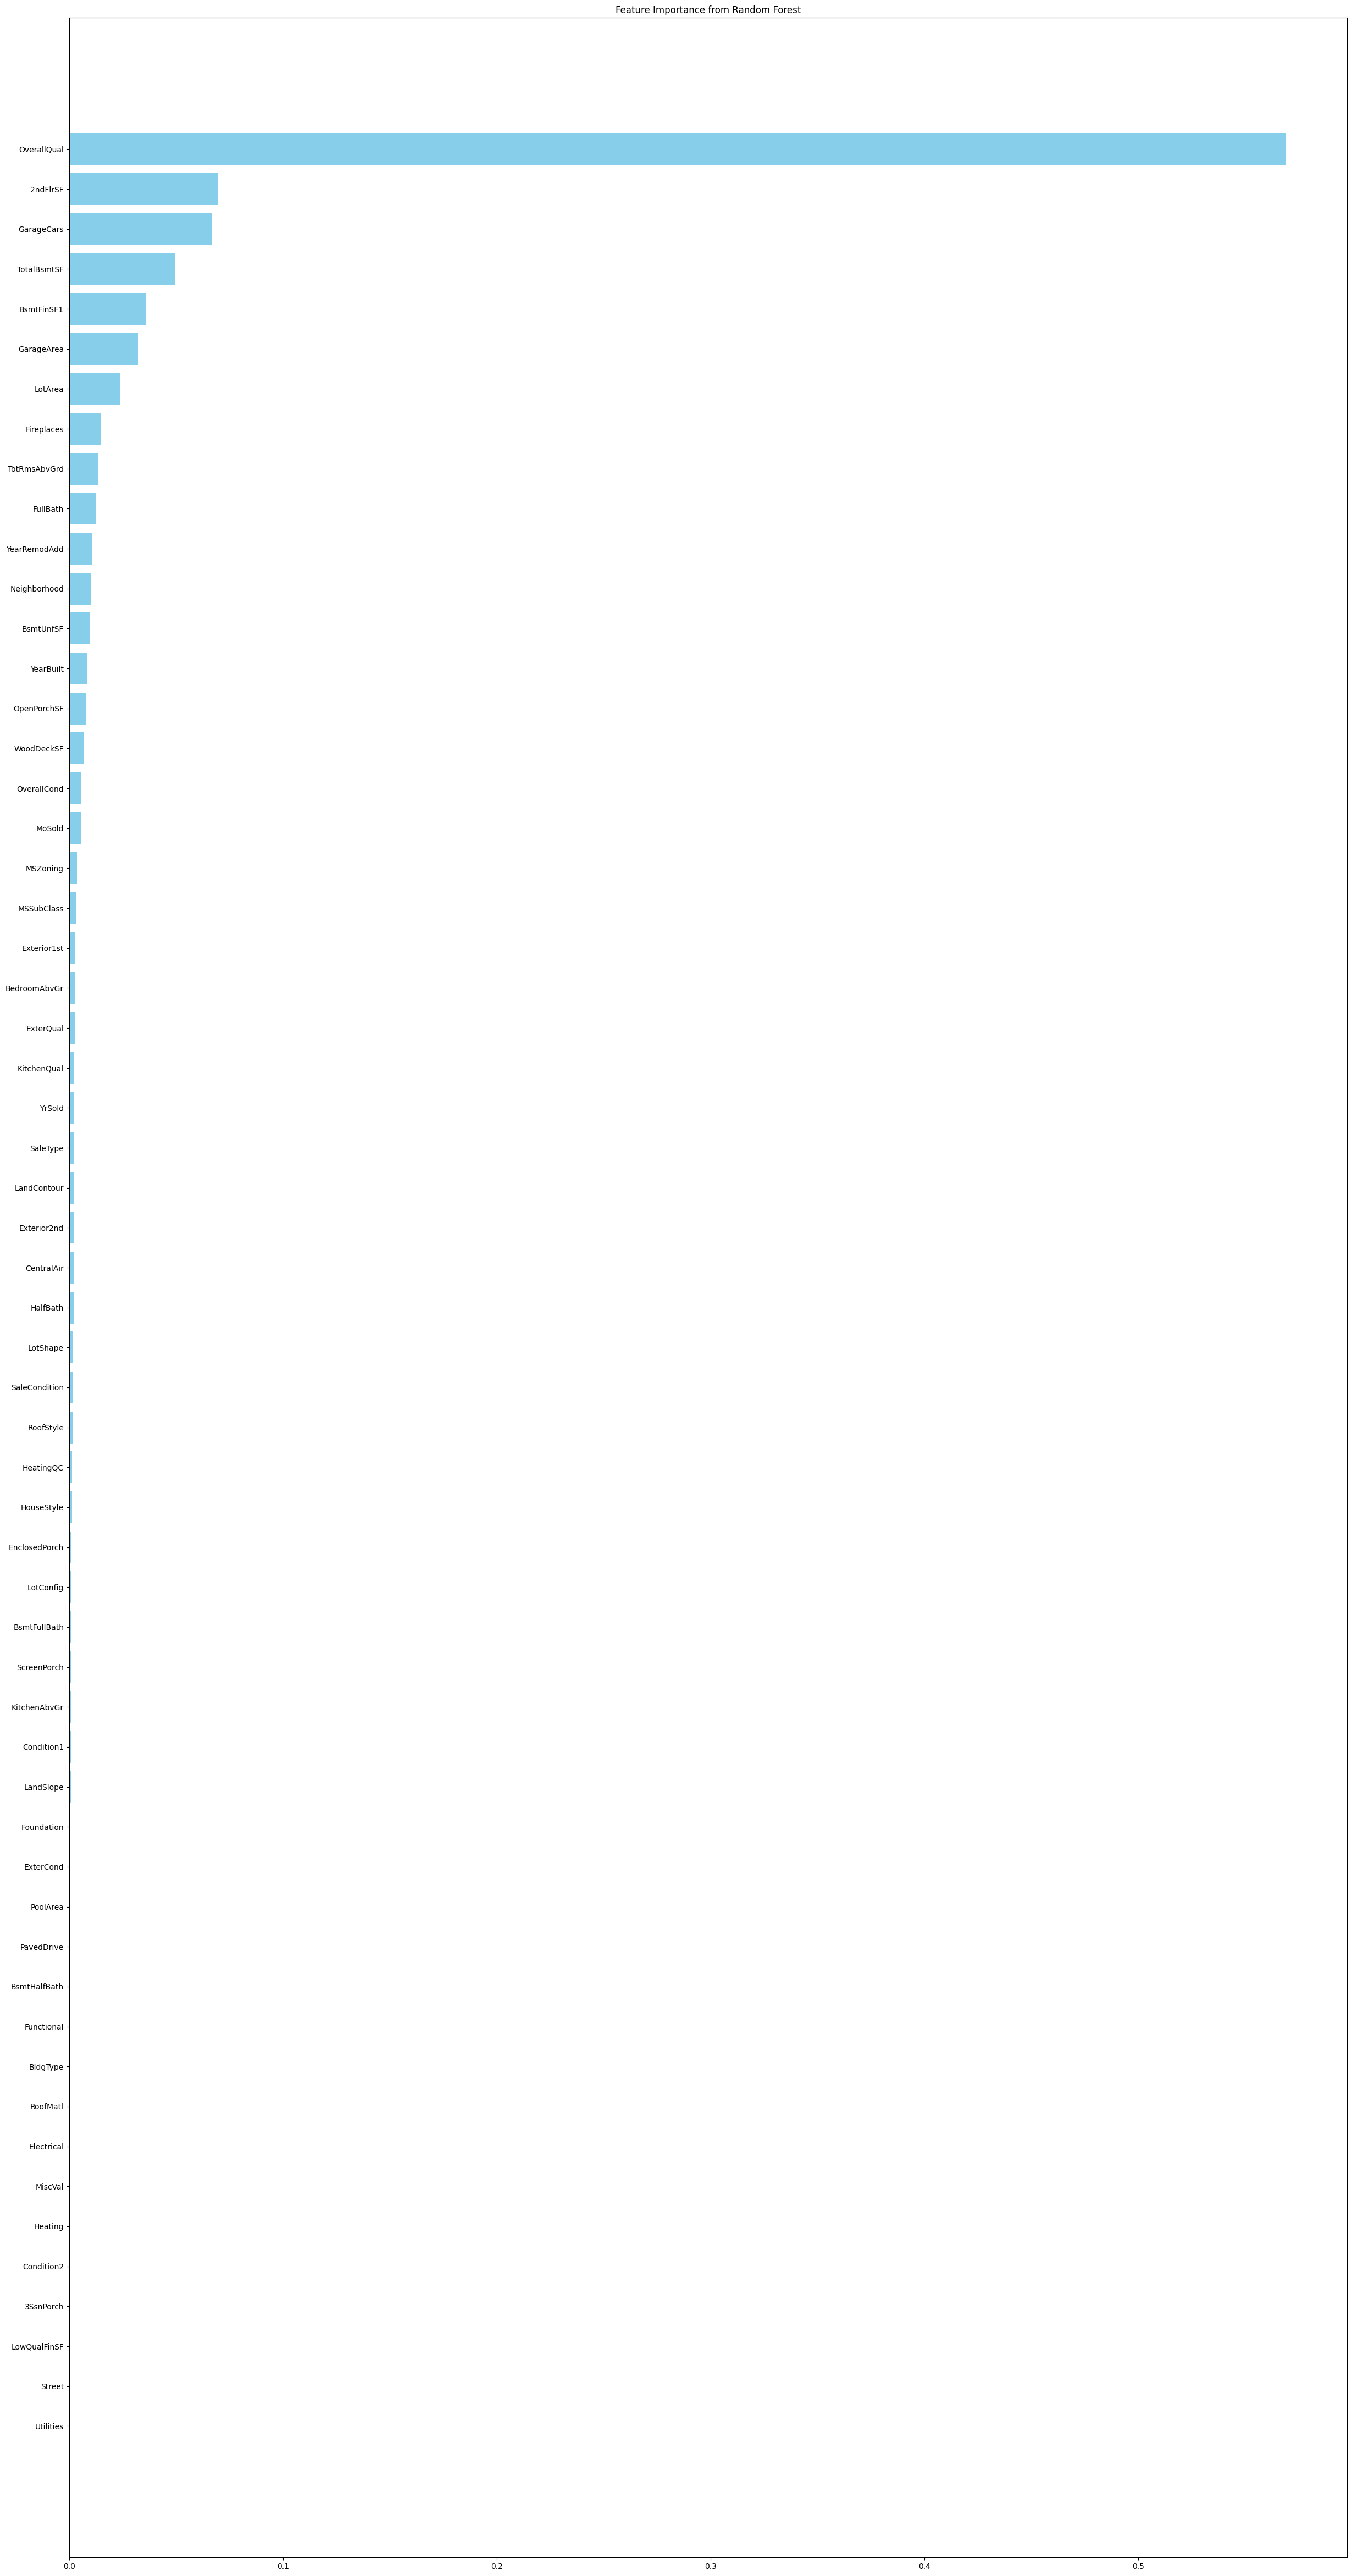

In [40]:
#Feature Importance
importances = rf.feature_importances_
feature_importance_df=pd.DataFrame({
    'Feature':X_train.columns,
    'Importance':importances
})

#sort dataframe by importance
feature_importance_df= feature_importance_df.sort_values(by='Importance',ascending=False)

#Plot
plt.figure(figsize=(30,60))
plt.barh(feature_importance_df['Feature'],feature_importance_df['Importance'],color='skyblue')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Submission

In [41]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
test_data

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub  ...         120        0    NaN  MnPrv   
1            Lvl    AllPub  ...           0        0    NaN    NaN   
2            Lvl    AllPub  ...           0        0    NaN  MnPrv   
3            Lvl    AllPub  ...           0        0    NaN    NaN   
4            HLS    AllPub  ...         144        0    NaN    NaN   
...          ...       ...  ...         ...      ...    ...    ...   
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0      6    2010        WD         Normal  
1           Gar2   12500      6    2010        WD         Normal  
2            NaN       0      3    2010        WD         Normal  
3            NaN       0      6    2010        WD         Normal  
4            NaN       0      1    2010        WD         Normal  
...          ...     ...    ...     ...       ...            ...  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[1459 rows x 80 columns]

In [42]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1459 non-null   int64 
 1   MSZoning       1459 non-null   object
 2   LotArea        1459 non-null   int64 
 3   Street         1459 non-null   object
 4   LotShape       1459 non-null   object
 5   LandContour    1459 non-null   object
 6   Utilities      1459 non-null   object
 7   LotConfig      1459 non-null   object
 8   LandSlope      1459 non-null   object
 9   Neighborhood   1459 non-null   object
 10  Condition1     1459 non-null   object
 11  Condition2     1459 non-null   object
 12  BldgType       1459 non-null   object
 13  HouseStyle     1459 non-null   object
 14  OverallQual    1459 non-null   int64 
 15  OverallCond    1459 non-null   int64 
 16  YearBuilt      1459 non-null   int64 
 17  YearRemodAdd   1459 non-null   int64 
 18  RoofStyle      1459 non-null   ob

In [44]:
# Get the columns from train (excluding SalePrice)
columns_to_keep = [col for col in train.columns if col != 'SalePrice']

# Reorder the columns in test_data to match train_data
test_data = test_data[columns_to_keep]

In [45]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotArea        1459 non-null   int64  
 3   Street         1459 non-null   object 
 4   LotShape       1459 non-null   object 
 5   LandContour    1459 non-null   object 
 6   Utilities      1457 non-null   object 
 7   LotConfig      1459 non-null   object 
 8   LandSlope      1459 non-null   object 
 9   Neighborhood   1459 non-null   object 
 10  Condition1     1459 non-null   object 
 11  Condition2     1459 non-null   object 
 12  BldgType       1459 non-null   object 
 13  HouseStyle     1459 non-null   object 
 14  OverallQual    1459 non-null   int64  
 15  OverallCond    1459 non-null   int64  
 16  YearBuilt      1459 non-null   int64  
 17  YearRemodAdd   1459 non-null   int64  
 18  RoofStyl

In [46]:
#missing data
total=test_data.isnull().sum().sort_values(ascending=False)
percent=(test_data.isnull().sum()/test_data.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total,percent], axis=1, keys=['Total','Percent'])
missing_data.head(20)

Total   Percent
MSZoning          4  0.002742
BsmtFullBath      2  0.001371
Utilities         2  0.001371
Functional        2  0.001371
BsmtHalfBath      2  0.001371
SaleType          1  0.000685
TotalBsmtSF       1  0.000685
BsmtUnfSF         1  0.000685
KitchenQual       1  0.000685
Exterior2nd       1  0.000685
GarageArea        1  0.000685
GarageCars        1  0.000685
Exterior1st       1  0.000685
BsmtFinSF1        1  0.000685
FullBath          0  0.000000
HalfBath          0  0.000000
BedroomAbvGr      0  0.000000
KitchenAbvGr      0  0.000000
MSSubClass        0  0.000000
TotRmsAbvGrd      0  0.000000

In [47]:
def random_value_imputation(feature):
    random_sample = test_data[feature].dropna().sample(test_data[feature].isna().sum())
    random_sample.index = test_data[test_data[feature].isnull()].index
    test_data.loc[test_data[feature].isnull(), feature] = random_sample
    
def impute_mode(feature):
    mode = test_data[feature].mode()[0]
    test_data[feature] = test_data[feature].fillna(mode)

# filling num_cols null values using random sampling method

for col in num_cols:
    random_value_imputation(col)

for col in cat_cols:
    impute_mode(col)

/tmp/ipykernel_30/3424134826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[feature] = test_data[feature].fillna(mode)


In [48]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   object 
 2   LotArea        1459 non-null   int64  
 3   Street         1459 non-null   object 
 4   LotShape       1459 non-null   object 
 5   LandContour    1459 non-null   object 
 6   Utilities      1459 non-null   object 
 7   LotConfig      1459 non-null   object 
 8   LandSlope      1459 non-null   object 
 9   Neighborhood   1459 non-null   object 
 10  Condition1     1459 non-null   object 
 11  Condition2     1459 non-null   object 
 12  BldgType       1459 non-null   object 
 13  HouseStyle     1459 non-null   object 
 14  OverallQual    1459 non-null   int64  
 15  OverallCond    1459 non-null   int64  
 16  YearBuilt      1459 non-null   int64  
 17  YearRemodAdd   1459 non-null   int64  
 18  RoofStyl

In [49]:
print(X_train.shape)  # Should be (n_samples, n_features)
print(y_train.shape)  # Should be (n_samples,)
print(test_data.shape)  # Should be (n_samples, n_features)

(1021, 58)
(1021,)
(1459, 58)


In [50]:
# Label to search for
label_to_search = 'RH'

# Iterate over columns
for column in test_data.columns:
    if label_to_search in test_data[column].values:
        print(f"Label '{label_to_search}' found in column '{column}'")

# Iterate over columns
for column in test_data.columns:
    if label_to_search in test_data[column].values:
        # Find the indices of rows containing the label
        affected_rows = test_data[test_data[column] == label_to_search]
        print(f"Label '{label_to_search}' found in column '{column}':")
        print(affected_rows)

Label 'RH' found in column 'MSZoning'
Label 'RH' found in column 'MSZoning':
      MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0             20       RH    11622   Pave      Reg         Lvl    AllPub   
10           120       RH     5858   Pave      IR1         Lvl    AllPub   
31            30       RH     9800   Pave      Reg         Lvl    AllPub   
99           190       RH     6048   Pave      Reg         Lvl    AllPub   
133           90       RH     7200   Pave      Reg         Lvl    AllPub   
436           50       RH     6300   Pave      Reg         Lvl    AllPub   
820          120       RH     4113   Pave      IR1         Lvl    AllPub   
821          120       RH    10943   Pave      IR2         Lvl    AllPub   
1181         120       RH     8773   Pave      IR2         Lvl    AllPub   
1414         190       RH     6430   Pave      Reg         Bnk    AllPub   

     LotConfig LandSlope Neighborhood  ... OpenPorchSF EnclosedPorch  \
0       Inside

In [51]:
# Label to compare
label_to_compare = 'RH'

# Check if label exists in both datasets
if label_to_compare in x['MSZoning'].values and label_to_compare in test_data['MSZoning'].values:
    # Compare the label in both datasets
    train_label = x.loc[x['MSZoning'] == label_to_compare, 'MSZoning'].iloc[0]
    test_label = test_data.loc[test_data['MSZoning'] == label_to_compare, 'MSZoning'].iloc[0]

    # Check for differences in case, whitespace, or encoding
    if train_label.strip().lower() != test_label.strip().lower():
        print("Difference found:")
        print(f"Train data: '{train_label}'")
        print(f"Test data: '{test_label}'")
    else:
        print("No differences found.")
else:
    print("Label 'RH' not found in one or both datasets.")

Label 'RH' not found in one or both datasets.


In [52]:
print("Unique values in test data:", test_data['MSZoning'].unique())

Unique values in test data: ['RH' 'RL' 'RM' 'FV' 'C (all)']


In [53]:
for col in cat_cols:
    test_data[col] = label_encoder.fit_transform(test_data[col])
test_data[num_cols] = scaler.transform(test_data[num_cols])

# Now you can make predictions using the scaled test data
predictions = best_model.predict(test_data) 

/tmp/ipykernel_30/3762432566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[col] = label_encoder.fit_transform(test_data[col])
/tmp/ipykernel_30/3762432566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[col] = label_encoder.fit_transform(test_data[col])
/tmp/ipykernel_30/3762432566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [54]:
# Prepare submission output
output = pd.DataFrame({'Id': test_data.index, 'SalePrice': predictions})

In [55]:
output

Id      SalePrice
0        0  118338.625000
1        1  162228.375000
2        2  182913.031250
3        3  189607.171875
4        4  205439.234375
...    ...            ...
1454  1454   74740.640625
1455  1455   81555.226562
1456  1456  179283.593750
1457  1457  125325.234375
1458  1458  235785.718750

[1459 rows x 2 columns]

In [56]:
output.to_csv('submission.csv', index=False)